<a href="https://colab.research.google.com/github/Singular-Brain/DeepBioLCNet/blob/main/Pretrain_BioLCNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Notebook setups

In [1]:
!pip install -q git+https://github.com/Singular-Brain/DeepBioLCNet

     |████████████████████████████████| 831.4 MB 2.7 kB/s 
     |████████████████████████████████| 22.1 MB 79.3 MB/s 
     |████████████████████████████████| 120 kB 73.4 MB/s 
     |████████████████████████████████| 77 kB 7.6 MB/s 
     |████████████████████████████████| 297 kB 88.9 MB/s 
     |████████████████████████████████| 38.1 MB 448 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.9.0 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.9.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
# !wget https://data.deepai.org/mnist.zip
# !mkdir -p ../data/MNIST/TorchvisionDatasetWrapper/raw
# !unzip mnist.zip -d ../data/MNIST/TorchvisionDatasetWrapper/raw/

In [2]:
!git clone https://github.com/Singular-Brain/DeepBioLCNet
# import bindsent


Cloning into 'DeepBioLCNet'...
remote: Enumerating objects: 882, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 882 (delta 1), reused 5 (delta 0), pack-reused 876
Receiving objects: 100% (882/882), 55.36 MiB | 12.58 MiB/s, done.
Resolving deltas: 100% (487/487), done.


In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.axes import Axes
from matplotlib.image import AxesImage
from torch.nn.modules.utils import _pair
from matplotlib.collections import PathCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from typing import Tuple, List, Optional, Sized, Dict, Union
import math
import random
# from ..utils import reshape_locally_connected_weights, reshape_locally_connected_weights_meh, reshape_conv2d_weights


In [4]:
from bindsnet.network.nodes import Nodes
import os
### import torch
import numpy as np
import copy
import math
import matplotlib.pyplot as plt
import collections
from torchvision import transforms
from torchvision import datasets
from tqdm.notebook import tqdm

from sklearn.metrics import confusion_matrix
import seaborn as sn
import torch.nn.functional as fn

from abc import ABC, abstractmethod
from typing import Union, Tuple, Optional, Sequence
from torch.nn.modules.utils import _pair

from bindsnet.datasets import MNIST
from bindsnet.encoding import PoissonEncoder, Encoder, NullEncoder
from bindsnet.network import Network
from bindsnet.network.nodes import Input, LIFNodes, AdaptiveLIFNodes, IFNodes
from bindsnet.network.topology import Connection, MaxPool2dLocalConnection
from bindsnet.network.topology import LocalConnection, LocalConnectionOrig
from bindsnet.network.monitors import Monitor, AbstractMonitor, TensorBoardMonitor
from bindsnet.learning import PostPre, MSTDP, MSTDPET, WeightDependentPostPre, Hebbian
from bindsnet.learning.reward import DynamicDopamineInjection, DopaminergicRPE
from bindsnet.analysis.plotting import plot_locally_connected_weights,plot_locally_connected_weights_meh,plot_spikes,\
plot_LC_timepoint_spikes,plot_locally_connected_weights_meh2,plot_convergence_and_histogram,plot_locally_connected_weights_meh3
from bindsnet.analysis.visualization import plot_weights_movie, plot_spike_trains_for_example,summary, plot_voltage
from bindsnet.utils import reshape_locally_connected_weights, reshape_locally_connected_weights_meh, reshape_conv2d_weights

## Sets up Gpu use and manual seed


In [5]:
if torch.cuda.is_available():
    device =  torch.device("cuda")
    gpu = True
else:
    device =  torch.device("cpu")
    gpu = False

def manual_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


SEED = 2045 # The Singularity is Near!
manual_seed(SEED)

WANDB = True
if WANDB:
    !pip install -q wandb
    import wandb
    wandb.login(key = "b6660e0033d6479f96e2ad280832f80ca1914088")

torch.set_num_threads(os.cpu_count() - 1)
print("Running on Device = ", device)


Running on Device =  cuda


# Custom Monitors

## Plots

In [6]:
from torch import Tensor
import torch.nn.functional as F
from numpy import ndarray
from typing import Tuple, Union
from torch.nn.modules.utils import _pair


def reshape_locally_connected_weights(
    w: Tensor,
    n_filters: int,
    kernel_size: Union[int, Tuple[int, int]],
    conv_size: Union[int, Tuple[int, int]],
    locations: Tensor,
    input_sqrt: Union[int, Tuple[int, int]],
) -> Tensor:
    # language=rst
    """
    Get the weights from a locally connected layer and reshape them to be two-dimensional and square.
    :param w: Weights from a locally connected layer.
    :param n_filters: No. of neuron filters.
    :param kernel_size: Side length(s) of convolutional kernel.
    :param conv_size: Side length(s) of convolution population.
    :param locations: Binary mask indicating receptive fields of convolution population neurons.
    :param input_sqrt: Sides length(s) of input neurons.
    :return: Locally connected weights reshaped as a collection of spatially ordered square grids.
    """
    kernel_size = _pair(kernel_size)
    conv_size = _pair(conv_size)
    input_sqrt = _pair(input_sqrt)

    k1, k2 = kernel_size
    c1, c2 = conv_size
    i1, i2 = input_sqrt
    c1sqrt, c2sqrt = int(math.ceil(math.sqrt(c1))), int(math.ceil(math.sqrt(c2)))
    fs = int(math.ceil(math.sqrt(n_filters)))

    w_ = torch.zeros((n_filters * k1, k2 * c1 * c2))

    for n1 in range(c1):
        for n2 in range(c2):
            for feature in range(n_filters):
                n = n1 * c2 + n2
                filter_ = w[
                    locations[:, n],
                    feature * (c1 * c2) + (n // c2sqrt) * c2sqrt + (n % c2sqrt),
                ].view(k1, k2)
                w_[feature * k1 : (feature + 1) * k1, n * k2 : (n + 1) * k2] = filter_

    if c1 == 1 and c2 == 1:
        square = torch.zeros((i1 * fs, i2 * fs))

        for n in range(n_filters):
            square[
                (n // fs) * i1 : ((n // fs) + 1) * i2,
                (n % fs) * i2 : ((n % fs) + 1) * i2,
            ] = w_[n * i1 : (n + 1) * i2]

        return square
    else:
        square = torch.zeros((k1 * fs * c1, k2 * fs * c2))

        for n1 in range(c1):
            for n2 in range(c2):
                for f1 in range(fs):
                    for f2 in range(fs):
                        if f1 * fs + f2 < n_filters:
                            square[
                                k1 * (n1 * fs + f1) : k1 * (n1 * fs + f1 + 1),
                                k2 * (n2 * fs + f2) : k2 * (n2 * fs + f2 + 1),
                            ] = w_[
                                (f1 * fs + f2) * k1 : (f1 * fs + f2 + 1) * k1,
                                (n1 * c2 + n2) * k2 : (n1 * c2 + n2 + 1) * k2,
                            ]

        return square
        
def plot_locally_connected_activations(
    weights: torch.Tensor,
    spikes : torch.Tensor,
    n_filters: int,
    in_chans: int,
    locations: torch.Tensor,
    input_size: int,
    kernel_size: Union[int, Tuple[int, int]],
    conv_size: Union[int, Tuple[int, int]],
    wmin: float = 0.0,
    wmax: float = 1.0,
    scale_factor : float = 1.0,
    im: Optional[AxesImage] = None,
    lines: bool = True,
    figsize: Tuple[int, int] = (5, 5),
    cmap: str = "hot_r",
    color: str='r'
) -> AxesImage:
    """
    Plot the activations of a 2D locally connected slice
    :param weights: Weight matrix of Conv2dConnection object.
    :param n_filters: No. of convolution kernels in use.
    :param in_channels: No. of input channels
    :param slice_to_plot: The 2D slice to plot
    :param input_size: The square input size
    :param kernel_size: Side length(s) of 2D convolution kernels.
    :param conv_size: Side length(s) of 2D convolution population.
    :param wmin: Minimum allowed weight value.
    :param wmax: Maximum allowed weight value.
    :param im: Used for re-drawing the weights plot.
    :param lines: Whether or not to draw horizontal and vertical lines separating input
        regions.
    :param figsize: Horizontal, vertical figure size in inches.
    :param cmap: Matplotlib colormap.
    :return: Used for re-drawing the weights plot.
    """
    x = scale_factor * spikes / torch.max(spikes)
    x = x.clip(wmin,wmax).repeat_interleave(kernel_size, dim=0).repeat_interleave(kernel_size, dim=1).cpu()
    n_sqrt = int(np.ceil(np.sqrt(n_filters)))

    # sel_slice = weights.view(in_chans, n_filters, conv_size, conv_size, kernel_size, kernel_size).cpu()
    # sel_slice = sel_slice[slice_to_plot, ...]

    reshaped = reshape_locally_connected_weights(
        weights, n_filters, kernel_size, conv_size, locations, input_size
    )

    if not im:
        fig, ax = plt.subplots(figsize=figsize)

        im = ax.imshow(reshaped.cpu()*x, cmap=cmap, vmin=wmin, vmax=wmax)
        div = make_axes_locatable(ax)
        cax = div.append_axes("right", size="5%", pad=0.05)
        kernel_size = _pair(kernel_size)
        conv_size = _pair(conv_size)
        
        if lines:
            for i in range(
                n_sqrt * kernel_size[0],
                n_sqrt * conv_size[0] * kernel_size[0],
                n_sqrt * kernel_size[0],
            ):
                ax.axhline(i - 0.5, color=color, linestyle="--")

            for i in range(
                n_sqrt * kernel_size[1],
                n_sqrt * conv_size[1] * kernel_size[1],
                n_sqrt * kernel_size[1],
            ):
                ax.axvline(i - 0.5, color=color, linestyle="--")

        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_aspect("auto")

        plt.colorbar(im, cax=cax)
        fig.tight_layout()
    else:
        im.set_data(reshaped)

    return im

## Reward Monitor

In [7]:
class RewardMonitor(AbstractMonitor):
    # language=rst
    """
    Records state variables of interest.
    """

    def __init__(
        self,
        time: None,
        batch_size: int = 1,
        device: str = "cpu",
    ):
        # language=rst
        """
        Constructs a ``Monitor`` object.

        :param obj: An object to record state variables from during network simulation.
        :param state_vars: Iterable of strings indicating names of state variables to record.
        :param time: If not ``None``, pre-allocate memory for state variable recording.
        :param device: Allow the monitor to be on different device separate from Network device
        """
        super().__init__()

        self.time = time
        self.batch_size = batch_size
        self.device = device

        # if time is not specified the monitor variable accumulate the logs
        if self.time is None:
            self.device = "cpu"

        self.recording = []
        self.reset_state_variables()

    def get(self,) -> torch.Tensor:
        # language=rst
        """
        Return recording to user.

        :return: Tensor of shape ``[time, n_1, ..., n_k]``, where ``[n_1, ..., n_k]`` is the shape of the recorded state
        variable.
        Note, if time == `None`, get return the logs and empty the monitor variable

        """
        # return_logs = torch.as_tensor(self.recording)
        # if self.time is None:
        #     self.recording = []
        return self.recording

    def record(self, **kwargs) -> None:
        # language=rst
        """
        Appends the current value of the recorded state variables to the recording.
        """
        if "reward" in kwargs:
            self.recording.append(kwargs["reward"])
        # remove the oldest element (first in the list)
        # if self.time is not None:
        #     self.recording.pop(0)

    def reset_state_variables(self) -> None:
        # language=rst
        """
        Resets recordings to empty ``List``s.
        """
        self.recording = []


# Design network

In [10]:
compute_size = lambda inp_size, k, s: int((inp_size-k)/s) + 1
def convergence(c):
    if c.norm is None:
        return 1-torch.mean((c.w-c.wmin)*(c.wmax-c.w))/((c.wmax-c.wmin)/2)**2
    else:
        mean_norm_factor = c.norm / c.w.shape[-1]
        return  1-(torch.mean((c.w-c.wmin)*(c.wmax-c.w))/((c.wmax-c.wmin)/2)**2)

        
class LCNet(Network):
    def __init__(
        self,
        n_classes: int,
        neuron_per_class: int,
        num_neurons_in_fc: int,
        in_channels : int,
        n_channels1: int,
        n_channels2: int,
        filter_size1: int,
        filter_size2: int,
        stride1: int,
        stride2: int,
        maxPool1: bool,
        maxPool2: bool,
        online: bool,
        deep: bool,
        time: int,
        reward_fn,
        n_neurons: int,
        pre_observation: bool,
        has_decision_period: bool,
        local_rewarding: bool,
        nu_LC: Union[float, Tuple[float, float]],
        nu_LC2: Union[float, Tuple[float, float]],
        nu_Output: float,
        dt: float,
        crop_size:int ,
        nu_inh_LC: float,
        nu_inh: float,
        nu_fc,
        inh_type,
        inh_LC: bool,
        inh_LC2: bool,
        inh_fc: bool,
        inh_factor_fc,
        inh_factor_LC: float,
        inh_factor_LC2: float,
        inh_factor:float,
        single_output_layer:bool,
        NodesType_LC,
        add_layer_fc,
        NodeType_FC,
        NodesType_Output, 
        update_rule_LC,
        update_rule_LC2,
        update_rule_fc,
        update_rule_Output,
        update_rule_inh,
        update_rule_inh_LC,
        wmin: float,
        wmax: float ,
        soft_bound,
        theta_plus: float,
        tc_theta_decay: float,
        tc_trace:int,
        normal_init:bool,
        mu: float,
        std:float,
        norm_factor_fc,
        norm_factor_inh_LC: bool,
        norm_factor_LC,
        norm_factor_LC2,
        norm_factor_out,
        norm_factor_inh,
        trace_additive,
        load_path,
        save_path,
        LC_weights_path,
        LC2_weights_path,
        confusion_matrix,
        lc_weights_vis,
        out_weights_vis,
        lc_convergence_vis,
        out_convergence_vis,
        thresh_LC,
        thresh_FC,
        wandb_active = False,
        batch_size=1,
        epocsh=1,
        **kwargs,
    ) -> None:
        # language=rst
        """
        Constructor for class ``BioLCNet``.

        :param n_inpt: Number of input neurons. Matches the 1D size of the input data.
        :param n_neurons: Number of excitatory, inhibitory neurons.
        :param exc: Strength of synapse weights from excitatory to inhibitory layer.
        :param inh: Strength of synapse weights from inhibitory to excitatory layer.
        :param dt: Simulation time step.
        :param nu: Single or pair of learning rates for pre- and post-synaptic events,
            respectively.
        :param reduction: Method for reducing parameter updates along the minibatch
            dimension.
        :param wmin: Minimum allowed weight on input to excitatory synapses.
        :param wmax: Maximum allowed weight on input to excitatory synapses.
        :param norm: Input to excitatory layer connection weights normalization
            constant.
        :param theta_plus: On-spike increment of ``(adaptive)LIFNodes`` membrane
            threshold potential.
        :param tc_theta_decay: Time constant of ``(adaptive)LIFNodes`` threshold
            potential decay.
        :param inpt_shape: The dimensionality of the input layer.
        """
        manual_seed(SEED)
        super().__init__(dt=dt, reward_fn = None, online=online)
        kwargs['single_output_layer'] = single_output_layer
        kwargs['dt'] = dt
        kwargs['n_labels'] = n_classes

        kwargs['neuron_per_class'] = neuron_per_class
        
        self.dt = dt
        self.reward_fn = reward_fn(**kwargs)
        self.batch_size = batch_size
        self.reward_fn.network = self
        self.reward_fn.dt = self.dt
        self.n_classes = n_classes
        self.neuron_per_class = neuron_per_class
        self.save_path = save_path
        self.load_path = load_path
        self.deep = deep
        self.add_layer_fc = add_layer_fc
        self.maxPool1 = maxPool1
        self.maxPool2 = maxPool2
        self.time = time
        self.crop_size = crop_size
        self.filter_size1 = filter_size1
        self.filter_size2 = filter_size2
        self.stride1 = stride1
        self.stride2 = stride2
        self.clamp_intensity = kwargs.get('clamp_intensity',None)
        self.single_output_layer = single_output_layer
        self.pre_observation = pre_observation
        self.has_decision_period = has_decision_period
        self.local_rewarding = local_rewarding
        self.soft_bound = soft_bound
        self.confusion_matrix = confusion_matrix
        self.lc_weights_vis = lc_weights_vis
        self.out_weights_vis = out_weights_vis
        self.lc_convergence_vis = lc_convergence_vis
        self.out_convergence_vis = out_convergence_vis
        self.in_channels = in_channels
        self.n_channels1 = n_channels1
        self.n_channels2 = n_channels2
        self.convergences = {}
        self.num_neurons_in_fc = num_neurons_in_fc
        self.norm_factor_LC = norm_factor_LC
        self.norm_factor_LC2 = norm_factor_LC2
        self.norm_factor_out = norm_factor_out
        self.wmin = wmin 
        self.wmax = wmax
        self.rates = None 
        self.out_spikes = []
        self.labels = []
        self.wandb_active = wandb_active
        self.epochs_trained = 0
        self.epochs = epochs

        self.time_analysis = kwargs.get('time_analysis', False)
        if kwargs['variant'] == 'scalar':
            assert self.has_decision_period == True, ''

        if self.online == False:
            assert self.has_decision_period == True, ''
        
        if self.has_decision_period == True:
            assert self.online == False, "Decision period is not compatible with online learning."
            self.observation_period = kwargs['observation_period']
            assert self.observation_period >= 0, ""
            self.decision_period = kwargs['decision_period']
            assert self.decision_period > 0, ""
            self.learning_period = self.time - self.observation_period - self.decision_period

        elif self.pre_observation == True:
            self.observation_period = kwargs['observation_period']
            assert self.observation_period >= 0, ""
            self.learning_period = self.time - self.observation_period
            self.decision_period = self.time - self.observation_period

        else:
            self.observation_period = 0
            self.decision_period = self.time
            self.learning_period = self.time

        ### nodes
        inp = Input(shape= [in_channels,crop_size,crop_size], traces=True, tc_trace=tc_trace,traces_additive = trace_additive)
        self.add_layer(inp, name="input")

        ## First hidden layer
        conv_size1 = compute_size(crop_size, filter_size1, stride1)
        main1 = NodesType_LC(shape= [n_channels1, conv_size1, conv_size1], thresh = thresh_LC, traces=True, tc_trace=tc_trace,
                             traces_additive = trace_additive,tc_theta_decay = tc_theta_decay, theta_plus = theta_plus)
        
        self.add_layer(main1, name="main1")

        ### connections 
        LC1 = LocalConnectionOrig(inp, main1, filter_size1, stride1, n_channels1,\
                              nu = _pair(nu_LC), update_rule = update_rule_LC,wmin = wmin, wmax= wmax, norm = norm_factor_LC)

        # LC1 = LocalConnection(inp, main1, filter_size1, stride1, in_channels, n_channels1,input_shape=(crop_size,crop_size),\
        #                      nu = _pair(nu_LC), update_rule = update_rule_LC,wmin = wmin, wmax= wmax, soft_bound = soft_bound, norm = norm_factor_LC)

        if LC_weights_path:
            a = torch.load(LC_weights_path)
            LC1.w.data = a['state_dict']['input_to_main.w']
            print("Weights loaded ...")
        
        elif normal_init:
            w_lc_init = torch.normal(mu,std, size = (in_channels, n_channels1 * compute_size(crop_size, filter_size1, stride1)**2, filter_size1**2))
            LC1.w.data = w_lc_init
       
        self.add_connection(LC1, "input", "main1")
        self.convergences['lc1'] = []

        if inh_LC:
            main_width = compute_size(crop_size, filter_size1, stride1)
            w_inh_LC = torch.zeros(n_channels1,main_width,main_width,n_channels1,main_width,main_width)
            for c in range(n_channels1):
                for w1 in range(main_width):
                    for w2 in range(main_width):
                        w_inh_LC[c,w1,w2,:,w1,w2] = - inh_factor_LC
                        w_inh_LC[c,w1,w2,c,w1,w2] = 0
        
            w_inh_LC = w_inh_LC.reshape(main1.n,main1.n)
                                                             
            LC_recurrent_inhibition = Connection(
                source=main1,
                target=main1,
                w=w_inh_LC,
            )
            self.add_connection(LC_recurrent_inhibition, "main1", "main1")
        
        
        self.final_connection_source_name = 'main1'
        self.final_connection_source = main1

        if self.add_layer_fc:
            FC1 = NodeType_FC(n= self.num_neurons_in_fc, traces=True,traces_additive = trace_additive, thresh=thresh_FC, tc_trace=tc_trace, tc_theta_decay = tc_theta_decay, theta_plus = theta_plus)

            self.add_layer(FC1, "fc1")

            main_fc = Connection(main1, FC1, nu = nu_fc, update_rule = update_rule_fc, wmin = wmin, wmax= wmax, norm = norm_factor_fc)
            
            self.add_connection(main_fc, "main1", "fc1")
            self.final_connection_source_name = 'fc1'
            self.final_connection_source = FC1

            if inh_fc:
                w = -inh_factor_fc * (torch.ones(FC1.n, FC1.n) - torch.eye(FC1.n, FC1.n))
                fc_recurrent_inhibition = Connection(
                    source=FC1,
                    target=FC1,
                    w=w,
                    update_rule = None,
                    wmin=-inh_factor_fc,
                    wmax=0,
                )
                self.add_connection(fc_recurrent_inhibition, "fc1", "fc1")

        self.hidden2 = main1
        self.hidden2_name = 'main1'
        if maxPool1:
            maxPool_kernel = 2
            maxPool_stride = 2
            
            conv_size1 =compute_size(conv_size1, maxPool_kernel, maxPool_stride)
            self.final_connection_source_name = 'maxpool1'
            
            maxpool1 = LIFNodes(shape= [self.n_channels1, conv_size1, conv_size1], refrac = 0)
            self.add_layer(maxpool1, name="maxpool1")
            self.final_connection_source = maxpool1
            
            maxPoolConnection = MaxPool2dLocalConnection(main1, maxpool1, maxPool_kernel, maxPool_stride)
            self.add_connection(maxPoolConnection, "main1", 'maxpool1')
            
            self.hidden2 = maxpool1
            self.hidden2_name = 'maxpool1'

        if deep:
            # # Second hidden layer
            conv_size2 = compute_size(conv_size1, filter_size2, stride2)

            main2 = NodesType_LC(shape= [n_channels2, conv_size2, conv_size2],traces=True, tc_trace=tc_trace,traces_additive = trace_additive,
                                            tc_theta_decay = tc_theta_decay, theta_plus = theta_plus)
            
            self.add_layer(main2, name="main2")

            ### connections 
            lc2_input_shape = (conv_size1,conv_size1)
            LC2 = LocalConnection(self.hidden2, main2, filter_size2, stride2, n_channels1, n_channels2, input_shape= lc2_input_shape,
            nu = _pair(nu_LC2), update_rule = update_rule_LC2, wmin = wmin, wmax= wmax, soft_bound = soft_bound, norm = norm_factor_LC2)

            self.add_connection(LC2,  self.hidden2_name, "main2")
            self.convergences['lc2'] = []
            if LC2_weights_path:
                a = torch.load(LC2_weights_path)
                LC2.w.data = a['state_dict']['main1_to_main2.w']
                print("Weights loaded ...")
            
            elif normal_init:
                w_lc_init = torch.normal(mu,std, size = (n_channels1, n_channels2 * compute_size(conv_size1, filter_size2, stride2)**2, filter_size2**2))
                LC2.w.data = w_lc_init

            self.final_connection_source_name = 'main2'
            self.final_connection_source = main2

            if inh_LC2:
                main_width = conv_size2
                w_inh_LC2 = torch.zeros(n_channels2,main_width,main_width,n_channels2,main_width,main_width)
                for c in range(n_channels2):
                    for w1 in range(main_width):
                        for w2 in range(main_width):
                            w_inh_LC2[c,w1,w2,:,w1,w2] = - inh_factor_LC2
                            w_inh_LC2[c,w1,w2,c,w1,w2] = 0
            
                w_inh_LC2 = w_inh_LC2.reshape(main2.n,main2.n)
                                                                
                LC_recurrent_inhibition2 = Connection(
                    source=main2,
                    target=main2,
                    w=w_inh_LC2,
                )
                self.add_connection(LC_recurrent_inhibition2, "main2", "main2")


            if maxPool2:
                maxPool_kernel = 2
                maxPool_stride = 2
                conv_size2 =compute_size(conv_size2, maxPool_kernel, maxPool_stride)
                self.final_connection_source_name = 'maxpool2'
                maxpool2 = LIFNodes(shape= [self.n_channels2, conv_size2, conv_size2], refrac = 0)
                self.final_connection_source = maxpool2
                maxPoolConnection2 = MaxPool2dLocalConnection(main2, maxpool2, maxPool_kernel, maxPool_stride)

                self.add_layer(maxpool2, name="maxpool2")
                self.add_connection(maxPoolConnection2, "main2", 'maxpool2')


        ### main2 to output
        out = NodesType_Output(n= n_neurons, traces=True,traces_additive = trace_additive, thresh=thresh_FC, tc_trace=tc_trace, tc_theta_decay = tc_theta_decay, theta_plus = theta_plus)

        self.add_layer(out, "output")

        last_main_out = Connection(self.final_connection_source, out, nu = nu_Output, update_rule = update_rule_Output, wmin = wmin, wmax= wmax, norm = norm_factor_out)

        if normal_init:
            w_last_main_init = torch.normal(mu,std,size = (self.final_connection_source.n,out.n)) 
            last_main_out.w.data = w_last_main_init
        #print(torch.mean(last_main_out.w),torch.std(last_main_out.w))    
        self.add_connection(last_main_out, self.final_connection_source_name, "output")
        self.convergences['last_main_out'] = []
        ### Inhibitory:
        if inh_type == 'between_layers':
            w = -inh_factor * torch.ones(out.n, out.n)
            for c in range(n_classes):
                ind = slice(c*neuron_per_class,(c+1)*neuron_per_class)
                w[ind, ind] = 0

            out_recurrent_inhibition = Connection(
                source=out,
                target=out,
                w=w,
                update_rule = update_rule_inh,
                wmin=-inh_factor,
                wmax=0,
                nu = nu_inh,
                norm = norm_factor_inh,
            )
            self.add_connection(out_recurrent_inhibition, "output", "output")
        elif inh_type == 'one_2_all':
            w = -inh_factor * (torch.ones(out.n, out.n) - torch.eye(out.n, out.n))
            out_recurrent_inhibition = Connection(
                source=out,
                target=out,
                w=w,
                update_rule = update_rule_inh,
                wmin=-inh_factor,
                wmax=0,
                nu = nu_inh,
                norm = norm_factor_inh,
            )
            self.add_connection(out_recurrent_inhibition, "output", "output")
        # Diehl and Cook
        elif inh_type == 'DC':
            raise NotImplementedError('Diehl and cook not implemented yet fo r 10 classes')

        # Directs network to GPU
        if gpu:
            self.to("cuda")


    def fit(
        self,
        dataloader,
        val_loader,
        reward_hparams,
        label = None,
        hparams = None,
        online_validate = True,
        n_train = 2000,
        n_test = 250,
        n_val = 250,
        val_interval = 250,
        running_window_length = 250,
        verbose = True,
    ):
        manual_seed(SEED)
        if self.wandb_active:
            wandb.watch(self)
        self.verbose = verbose
        self.label = label
        # add Monitors
        #main_monitor = Monitor(self.layers["main"], ["v"], time=None, device=device)
        reward_monitor = RewardMonitor(time =self.time)
        #Plot_et = PlotET(i = 0, j = 0, source = self.layers["main"], target = self.layers["output"], connection = self.connections[("main","output")])
        #tensorboard = TensorBoardMonitor(self, time = self.time)
        #self.add_monitor(main_monitor, name="main")
        self.add_monitor(reward_monitor, name="reward")
        #self.add_monitor(Plot_et, name="Plot_et")
        #self.add_monitor(tensorboard, name="tensorboard")

            
        acc_hist = collections.deque([], running_window_length)

        #if self.single_output_layer:
        self.spikes = {}
        for layer in set(self.layers):
            self.spikes[layer] = Monitor(self.layers[layer], state_vars=["s"], time=None)
            self.add_monitor(self.spikes[layer], name="%s_spikes" % layer)
            self.dopaminergic_layers = self.layers["output"]
        # else:
        #     output_layers = set([layer for layer in self.layers if layer.startswith('output')])
        #     self.output_spikes = {}
        #     for layer in output_layers:
        #         self.output_spikes[layer] = Monitor(self.layers[layer], state_vars=["s"], time=self.time)
        #         self.add_monitor(self.output_spikes[layer], name="%s_spikes" % layer)
        #         self.dopaminergic_layers = {name: layer for name, layer in self.layers.items() if name.startswith('output')}

        val_acc = 0.0
        acc = 0.0

        reward_history = []
        if self.load_path:
            # try:
            self.model_params = torch.load(self.load_path)
            self.load_state_dict(torch.load(self.load_path)['state_dict'])
            iteration =  self.model_params['iteration']
            hparams = self.model_params['hparams']
            train_accs = self.model_params['train_accs']
            val_accs = self.model_params['val_accs']
            acc_rewards = self.model_params['acc_rewards']
            print(f'Previous model loaded! Resuming training from iteration {iteration}..., last running training accuracy: {train_accs[-1]}, last validation accuracy: {val_accs[-1]}\n') if self.verbose else None
        else:
            print(f'Previous model not found! Training from the beginning...\n') if self.verbose else None
            val_accs = []
            train_accs = []
            acc_rewards = []
            # except:
            #     pass
        pbar = tqdm(total=n_train)
        self.reset_state_variables()

        reward_hparams['constant_rew'] =True
        
        if self.time_analysis:
            self.sample_spikes = {'input': [], 'main1': [], 'output': []}

        for epoch in range(self.epochs):
            for (i, data) in enumerate(dataloader):
                if self.load_path:
                    #try:
                    if i*self.batch_size <= iteration:
                        n_train += self.batch_size
                        continue
                    # except:
                    #     pass
                if i*self.batch_size > n_train:
                    break

                image = data["encoded_image"]
                if self.label is None : label = data["label"]

                # Run the network on the input.
                if gpu:
                    inputs = {"input": torch.transpose(image.cuda(),0,1)}
                else:
                    inputs = {"input": torch.transpose(image,0,1)}
                #print(self.spikes['output'].get('s'))

                ### Spike clamping (baseline activity)

                clamp = {}
                if self.clamp_intensity is not None:
                    encoder = PoissonEncoder(time = self.time, dt = self.dt)
                    clamp['output'] = encoder.enc(datum = torch.rand(self.layers['output'].n)*self.clamp_intensity,time = self.time, dt = self.dt)

                
                self.run(inputs=inputs, 
                        time=self.time, 
                        **reward_hparams,
                        one_step=True,
                        true_label = label,
                        dopaminergic_layers= self.dopaminergic_layers,
                        clamp = clamp
                        )

                # print(net.connections[("input","main1")].w[0,0])
                # Get voltage recording.
                #main_voltage = main_monitor.get("v")
                reward =reward_monitor.get()
                reward_history.append(reward)
                #tensorboard.update(step= i)

                # Add to spikes recording.
                #if self.single_output_layer:
                lc_spikes1 = self.spikes['main1'].get('s')
                #fc_spikes1 = self.spikes['fc1'].get('s')

                # out_spikes = self.spikes["output"].get("s").view(self.time, self.batch_size, n_classes, neuron_per_class)
                # sum_spikes = out_spikes[self.observation_period:self.observation_period+self.decision_period,:,:].sum(0).sum(2)
                # predicted_label = torch.argmax(sum_spikes, dim=1)
                
                out_spikes = self.spikes["output"].get("s").view(self.batch_size,self.time, -1)[:, self.observation_period:self.observation_period+self.decision_period,:]
                
                self.out_spikes.append(out_spikes)
                self.labels.append(label)
                class_votes = torch.zeros((self.n_classes))
                sum_spikes = out_spikes.sum(1).squeeze()

                if i>val_interval:

                    for i in range(self.n_classes):
                        neuron_for_label = (self.assignments == i).sum()
                        if neuron_for_label == 0:
                            class_votes[i] = 0
                        else:

                            class_votes[i] = sum_spikes[self.assignments == i].sum()/neuron_for_label
                    predicted_label = torch.argmax(class_votes)
                    print('\rclass votes: ', class_votes, ', pred_label:', predicted_label, 'GT:', label, ', Acc Rew:', sum(reward_monitor.get()), end='')

                else:
                    predicted_label = 0
                    print('\rpred_label:', predicted_label, 'GT:', label, ', Acc Rew:', sum(reward_monitor.get()), end = '')

                if self.time_analysis:
                    self.sample_spikes['input'].append(self.spikes['input'].get('s'))
                    self.sample_spikes['main1'].append(self.spikes['main1'].get('s'))
                    self.sample_spikes['output'].append(self.spikes['output'].get('s').view(self.time, self.batch_size,n_classes, neuron_per_class))

                # else:
                #     spikes_record = torch.zeros(self.n_classes, self.time, self.neuron_per_class)
                #     for c in range(self.n_classes):
                #         spikes_record[c] = self.output_spikes[f"output_{c}"].get("s").squeeze(1)
                #     sum_spikes = spikes_record.sum(1).sum(1)
                #     predicted_label = torch.argmax(sum_spikes)    

                acc_hist.append((predicted_label == label).sum())
    
                w_lc1 = self.connections[('input', 'main1')].w
                w_last_main_out = self.connections[(self.final_connection_source_name,'output')].w
                #w_lc2 = self.connections[('main1', 'main2')].w
                #w_inh = self.connections[('output','output')].w
                convg_lc1=  1 -  torch.mean((w_lc1 - self.wmin)*(self.wmax-w_lc1))
                convg_out= 1 -  torch.mean((w_last_main_out - self.wmin)*(self.wmax-w_last_main_out))
                if self.norm_factor_LC is not None:
                    mean_norm_factor_lc = self.norm_factor_LC / w_lc1.shape[-1]
                    convg_lc1=  1 - ( torch.mean((w_lc1 - self.wmin)*(self.wmax-w_lc1)) / ((mean_norm_factor_lc - self.wmin)*(self.wmax - mean_norm_factor_lc)) )
                if self.norm_factor_out is not None:    
                    mean_norm_factor_out = self.norm_factor_out / w_last_main_out.shape[-2]
                    convg_out= 1 - ( torch.mean((w_last_main_out - self.wmin)*(self.wmax-w_last_main_out)) / ((mean_norm_factor_out - self.wmin)*(self.wmax - mean_norm_factor_out)) )
            
                self.convergences['lc1'].append((convg_lc1 * 10**4).round() / (10**4))
                self.convergences['last_main_out'].append((convg_out * 10**4).round() / (10**4)) 
                #print(sum_spikes.shape)


                
                acc = 100 * sum(acc_hist)/(len(acc_hist)*self.batch_size)
                if self.wandb_active:
                    wandb.log({
                            **{' to '.join(name) + ' convergence': convergence(c).item() for name, c in self.connections.items() if name[0]!=name[1]},
                            **{'training accuracy': acc},
                            **{"Reward": sum(sum(reward))},
                            **{' to '.join(name) + ' std': c.w.std().item() for name, c in self.connections.items() if name[0]!=name[1]},
                            **{name + ' spikes': monitor.get('s').sum().item() for name, monitor in self.spikes.items()},
                            **{' to '.join(name) + " weights": wandb.Histogram(c.w.cpu()) for name, c in self.connections.items() if name[0]!=name[1]},
                        },
                        step = self.epochs_trained)


                
                self.reward_fn.update(accumulated_reward= sum(reward_monitor.get()), ema_window = reward_hparams['ema_window']) 

                if online_validate and i % val_interval == 0 and i!=0:
                    if reward_hparams['constant_rew']:
                        reward_hparams['constant_rew'] = False
                    self.reset_state_variables()
                    val_acc = self.evaluate(val_loader, n_val, val_interval, running_window_length)
                    #tensorboard.writer.add_scalars("accuracy", {"train": acc, "val" : val_acc}, i)
                    train_accs.append(acc)
                    val_accs.append(val_acc)
                    #acc_rewards.append(sum(reward_monitor.get()))
                    if self.save_path is not None:
                        model_params = {'state_dict': self.state_dict(), 'hparams': hparams, 'iteration': i, 'val_accs': val_accs, 'train_accs': train_accs, 'acc_rewards': acc_rewards}
                        torch.save(model_params, self.save_path)
                # else:
                #     pass
                    #tensorboard.writer.add_scalars("accuracy", {"train": acc}, i)
                #tensorboard.writer.add_scalar("reward", sum(reward_monitor.get()), i)

                # if  i % val_interval == 0 and i!=0:
                #     fig = create_plot(self.output_spikes, reward_monitor.get(), label)
                #     tensorboard.writer.add_figure('reward', fig, i)
                
                #Plot_et.plot()    
                self.reset_state_variables()  # Reset state variables.
                
                pbar.set_description_str("Epoch: "+str(epoch)+", Running accuracy: " + "{:.2f}".format(acc) + "%, " + "Current val accuracy: " + "{:.2f}".format(val_acc) + "%, ")
                pbar.update(len(label))

                self.epochs_trained += 1

        result_metrics = {'train_acc': acc, 'val_acc': val_acc}
        # tensorboard.writer.add_hparams(
        #     {k:(v if type(v) in (int, float, bool, str, torch.Tensor) else str(v)) for k,v in {**train_hparams, **data_hparams, **network_hparams, **reward_hparams}.items() },
        #     result_metrics
        # )
    
    def predict(self, dataloader, idx,  reward_hparams, label = None):
        reward_monitor = RewardMonitor(time =self.time)

        for i, data in enumerate(dataloader):
            if i*self.batch_size == idx:
                image = data["encoded_image"]
                if self.label is None : label = data["label"]

        # Run the network on the input.
        if gpu:
            inputs = {"input": torch.transpose(image.cuda(),0,1)}
        else:
            inputs = {"input": torch.transpose(image,0,1)}

        clamp = {}
        if self.clamp_intensity is not None:
            encoder = PoissonEncoder(time = self.time, dt = self.dt)
            clamp['output'] = encoder.enc(datum = torch.rand(self.layers['output'].n)*self.clamp_intensity,time = self.time, dt = self.dt)

        self.run(inputs=inputs, 
                time=self.time, 
                **reward_hparams,
                one_step=True,
                true_label = label,
                dopaminergic_layers= self.dopaminergic_layers,
                clamp = clamp
                    )
        
        out_spikes = self.spikes["output"].get("s").view(self.time, self.batch_size, n_classes, neuron_per_class)
        sum_spikes = out_spikes[self.observation_period:self.observation_period+self.decision_period,:,:].sum(0).sum(2)
        predicted_label = torch.argmax(sum_spikes, dim=1)

        if self.time_analysis:
            self.sample_spikes['input'].append(self.spikes['input'].get('s'))
            self.sample_spikes['main1'].append(self.spikes['main1'].get('s'))
            self.sample_spikes['output'].append(self.spikes['output'].get('s').view(self.time, self.batch_size, n_classes, neuron_per_class))

        w_lc1 = self.connections[('input', 'main1')].w
        w_last_main_out = self.connections[(self.final_connection_source_name,'output')].w
        #w_lc2 = self.connections[('main1', 'main2')].w
        #w_inh = self.connections[('output','output')].w
        convg_lc1=  1 -  torch.mean((w_lc1 - self.wmin)*(self.wmax-w_lc1))
        convg_out= 1 -  torch.mean((w_last_main_out - self.wmin)*(self.wmax-w_last_main_out))
        if self.norm_factor_LC is not None:
            mean_norm_factor_lc = self.norm_factor_LC / w_lc1.shape[-1]
            convg_lc1=  1 - ( torch.mean((w_lc1 - self.wmin)*(self.wmax-w_lc1)) / ((mean_norm_factor_lc - self.wmin)*(self.wmax - mean_norm_factor_lc)) )
        if self.norm_factor_out is not None:    
            mean_norm_factor_out = self.norm_factor_out / w_last_main_out.shape[-2]
            convg_out= 1 - ( torch.mean((w_last_main_out - self.wmin)*(self.wmax-w_last_main_out)) / ((mean_norm_factor_out - self.wmin)*(self.wmax - mean_norm_factor_out)) )
        
        self.convergences['lc1'].append((convg_lc1 * 10**4).round() / (10**4))
        self.convergences['last_main_out'].append((convg_out * 10**4).round() / (10**4)) 
    
        # print("\routput", sum_spikes, 'pred_label:',
        #     predicted_label, 'GT:', label,
        #     ', Acc Rew:', round(sum(reward_monitor.get()).item(),4),
        #     f"Pos dps: {self.reward_fn.dps:.5f}, Neg dps: {self.reward_fn.neg_dps:.5f}, Rew base: {self.reward_fn.rew_base:.5f}, Pun base: {self.reward_fn.punish_base:.5f}, RPe: {self.reward_fn.reward_predict_episode:.3f}",
        #     f"input_mean_fire_freq: {torch.mean(image.float())*1000:.1f},main_mean_fire_freq:{torch.mean(lc_spikes1.float())*1000:.1f}",#" main2_mean_fire_freq:{torch.mean(lc_spikes2.float())*1000:.1f}",
        #     f"output_mean_fire_freq:{torch.mean(out_spikes.float())*1000:.1f}",
        #     f"mean_lc1_w: {torch.mean(w_lc1):.5f}, mean_fc_w:{torch.mean(w_last_main_out):.5f}",
        #     f"std_lc1_w: {torch.std(w_lc1):.5f}, std_fc_w:{torch.std(w_last_main_out):.5f}",
        #     f"convergence_lc1: {convg_lc1:.5f}, convergence_fc: {convg_out:.5f}",
        #     end = '')           
        
        # acc = 100 * sum(acc_hist)/(len(acc_hist)*self.batch_size)
        
        self.reward_fn.update(accumulated_reward= sum(reward_monitor.get()), ema_window = reward_hparams['ema_window']) 
        
        self.reset_state_variables()  # Reset state variables.

        return label, predicted_label, reward_monitor.get() 

    def evaluate(self, val_loader, n_val, val_interval, running_window_length):
        self.out_spikes = torch.cat(self.out_spikes, dim=0)
        self.labels = torch.cat(self.labels, dim=0)
        
        self.assignments, _, self.rates = assign_labels(self.out_spikes, self.labels, self.n_classes, self.rates, alpha = 0.99)

        self.out_spikes = []
        self.labels = []
        manual_seed(SEED)
        acc_hist_val = collections.deque([], running_window_length)
        
        spikes_val = {}

        self.train(False)
        self.learning = False

        GT, y_pred = [], []
        for (i, data) in enumerate(val_loader):
            if i*self.batch_size > n_val:
                break

            image = data["encoded_image"]
            if self.label is None : 
              label = data["label"]
            else :
              label = self.label

            # Run the network on the input.
            if gpu:
                inputs = {"input": torch.transpose(image.cuda(),0,1)}
            else:
                inputs = {"input": torch.transpose(image,0,1)}

            self.run(inputs=inputs, 
                    time=self.time, 
                    **reward_hparams,
                    one_step = True,
                    true_label = label,
                    dopaminergic_layers= self.dopaminergic_layers,
                     )
            # Add to spikes recording.
            #if self.single_output_layer:
            # out_spikes = self.spikes["output"].get("s").view(self.time, self.batch_size, n_classes, neuron_per_class)
            # sum_spikes = out_spikes[self.observation_period:self.observation_period+self.decision_period,:,:].sum(0).sum(2)
            # predicted_label = torch.argmax(sum_spikes, dim=1)
            out_spikes = self.spikes["output"].get("s").view(self.batch_size,self.time, -1)[:, self.observation_period:self.observation_period+self.decision_period,:]

            class_votes = torch.zeros((self.n_classes))
            sum_spikes = out_spikes.sum(1).squeeze()
            for i in range(self.n_classes):
                neuron_for_label = (self.assignments == i).sum()
                if neuron_for_label == 0:
                    class_votes[i] = 0
                else:
                    class_votes[i] = sum_spikes[self.assignments == i].sum()/neuron_for_label
            predicted_label = torch.argmax(class_votes)
            # else:
            #     spikes_record = torch.zeros(self.n_classes, self.time, self.neuron_per_class)
            #     for c in range(self.n_classes):
            #         spikes_record[c] = self.output_spikes[f"output_{c}"].get("s").squeeze(1)
            #     sum_spikes = spikes_record.sum(1).sum(1)
            #     predicted_label = torch.argmax(sum_spikes)

            acc_hist_val.append((predicted_label == label).sum())
            
            GT.append(label)
            y_pred.append(predicted_label)
            
            # print("\r*validation: output",sum_spikes,
            #     'predicted_label:', predicted_label, 'GT:', label,
            #     end = '') if self.verbose else None
            
            self.reset_state_variables()  # Reset state variables.

        self.train(True)
        self.learning = True
        
        if self.confusion_matrix:
            self.plot_confusion_matrix(GT, y_pred)

        if self.lc_weights_vis:
            plot_locally_connected_weights_meh(self.connections[('input','main1')].w,self.n_channels1,self.in_channels,0,self.crop_size,self.filter_size1,self.layers['main1'].shape[1])
            plt.show()
            if self.deep:
                plot_locally_connected_weights_meh(self.connections[(self.hidden2_name,'main1')].w,self.n_channels2,self.n_channels1,0,self.layers[self.hidden2_name].shape[1],self.filter_size2,self.layers['main2'].shape[1])                
                plt.show()
        
        if self.lc_convergence_vis: 
            plot_convergence_and_histogram(self.connections[('input','main1')].w,self.convergences['lc1'])
            plt.show()
        if self.out_convergence_vis:
            plot_convergence_and_histogram(self.connections[(self.final_connection_source_name,'output')].w,self.convergences['last_main_out'])
            plt.show() 

        if self.out_weights_vis:
            plot_locally_connected_weights_meh3(self.connections[('input','main1')].w,self.connections[(self.final_connection_source_name,'output')].w,\
                                                0,0,self.neuron_per_class,self.n_channels1,self.in_channels,0,self.crop_size,self.filter_size1,self.layers['main1'].shape[1]) 
            plt.show()
            plot_locally_connected_weights_meh3(self.connections[('input','main1')].w,self.connections[(self.final_connection_source_name,'output')].w,\
                                                0,1,self.neuron_per_class,self.n_channels1,self.in_channels,0,self.crop_size,self.filter_size1,self.layers['main1'].shape[1])           
            plt.show()
        val_acc = 100 * sum(acc_hist_val)/(len(acc_hist_val)*self.batch_size)
        return val_acc

    @staticmethod
    def plot_confusion_matrix(GT, y_predicted):
        cm = confusion_matrix(GT, y_predicted)
        plt.figure(figsize = (10,7))
        sn.heatmap(cm, annot=True)
        plt.xlabel('Predicted')
        plt.ylabel('Truth')
        plt.show()

    
    def one_step(self,datum,label = None):
        self.reset_state_variables()
        
        image = datum["encoded_image"]
        if label is None : label = datum["label"]

        if gpu:
            inputs = {"input": torch.transpose(image.cuda(),0,1)}
        else:
            inputs = {"input": torch.transpose(image,0,1)}

        clamp = {}
        if self.clamp_intensity is not None:
            encoder = PoissonEncoder(time = self.time, dt = self.dt)
            clamp['output'] = encoder.enc(datum = torch.rand(self.layers['output'].n)*self.clamp_intensity,time = self.time, dt = self.dt)

        self.run(inputs=inputs, 
                time=self.time, 
                **reward_hparams,
                one_step = True,
                true_label = label,
                dopaminergic_layers= self.dopaminergic_layers,
                )
    

## LCNet 2

In [11]:
compute_size = lambda inp_size, k, s: int((inp_size-k)/s) + 1
def convergence(c):
    if c.norm is None:
        return 1-torch.mean((c.w-c.wmin)*(c.wmax-c.w))/((c.wmax-c.wmin)/2)**2
    else:
        mean_norm_factor = c.norm / c.w.shape[-1]
        return  1-(torch.mean((c.w-c.wmin)*(c.wmax-c.w))/((c.wmax-c.wmin)/2)**2)

        
class LCNet2(Network):
    def __init__(
        self,
        n_classes: int,
        neuron_per_class: int,
        in_channels : int,
        n_channels1: int,
        n_channels2: int,
        filter_size1: int,
        filter_size2: int,
        stride1: int,
        stride2: int,
        maxPool1: bool,
        maxPool2: bool,
        online: bool,
        deep: bool,
        time: int,
        reward_fn,
        n_neurons: int,
        pre_observation: bool,
        has_decision_period: bool,
        local_rewarding: bool,
        nu_LC: Union[float, Tuple[float, float]],
        nu_LC2: Union[float, Tuple[float, float]],
        nu_Output: float,
        dt: float,
        crop_size:int ,
        nu_inh_LC: float,
        nu_inh: float,
        inh_type,
        inh_LC: bool,
        inh_LC2: bool,
        inh_factor_LC: float,
        inh_factor_LC2: float,
        inh_factor:float,
        single_output_layer:bool,
        NodesType_LC,
        NodesType_Output, 
        update_rule_LC,
        update_rule_LC2,
        update_rule_Output,
        update_rule_inh,
        update_rule_inh_LC,
        wmin: float,
        wmax: float ,
        soft_bound,
        theta_plus: float,
        tc_theta_decay: float,
        tc_trace:int,
        normal_init:bool,
        mu: float,
        std:float,
        norm_factor_inh_LC: bool,
        norm_factor_LC,
        norm_factor_LC2,
        norm_factor_out,
        norm_factor_inh,
        trace_additive,
        load_path,
        save_path,
        LC_weights_path,
        LC2_weights_path,
        confusion_matrix,
        lc_weights_vis,
        out_weights_vis,
        lc_convergence_vis,
        out_convergence_vis,
        thresh_LC,
        thresh_FC,
        wandb_active = False,
        batch_size=1,
        epocsh=1,
        **kwargs,
    ) -> None:
        # language=rst
        """
        Constructor for class ``BioLCNet``.

        :param n_inpt: Number of input neurons. Matches the 1D size of the input data.
        :param n_neurons: Number of excitatory, inhibitory neurons.
        :param exc: Strength of synapse weights from excitatory to inhibitory layer.
        :param inh: Strength of synapse weights from inhibitory to excitatory layer.
        :param dt: Simulation time step.
        :param nu: Single or pair of learning rates for pre- and post-synaptic events,
            respectively.
        :param reduction: Method for reducing parameter updates along the minibatch
            dimension.
        :param wmin: Minimum allowed weight on input to excitatory synapses.
        :param wmax: Maximum allowed weight on input to excitatory synapses.
        :param norm: Input to excitatory layer connection weights normalization
            constant.
        :param theta_plus: On-spike increment of ``(adaptive)LIFNodes`` membrane
            threshold potential.
        :param tc_theta_decay: Time constant of ``(adaptive)LIFNodes`` threshold
            potential decay.
        :param inpt_shape: The dimensionality of the input layer.
        """
        manual_seed(SEED)
        super().__init__(dt=dt, reward_fn = None, online=online)
        kwargs['single_output_layer'] = single_output_layer
        kwargs['dt'] = dt
        kwargs['n_labels'] = n_classes
        kwargs['neuron_per_class'] = neuron_per_class
        
        self.dt = dt
        self.reward_fn = reward_fn(**kwargs)
        self.batch_size = batch_size
        self.reward_fn.network = self
        self.reward_fn.dt = self.dt
        self.n_classes = n_classes
        self.neuron_per_class = neuron_per_class
        self.save_path = save_path
        self.load_path = load_path
        self.deep = deep
        self.maxPool1 = maxPool1
        self.maxPool2 = maxPool2
        self.time = time
        self.crop_size = crop_size
        self.filter_size1 = filter_size1
        self.filter_size2 = filter_size2
        self.stride1 = stride1
        self.stride2 = stride2
        self.clamp_intensity = kwargs.get('clamp_intensity',None)
        self.single_output_layer = single_output_layer
        self.pre_observation = pre_observation
        self.has_decision_period = has_decision_period
        self.local_rewarding = local_rewarding
        self.soft_bound = soft_bound
        self.confusion_matrix = confusion_matrix
        self.lc_weights_vis = lc_weights_vis
        self.out_weights_vis = out_weights_vis
        self.lc_convergence_vis = lc_convergence_vis
        self.out_convergence_vis = out_convergence_vis
        self.in_channels = in_channels
        self.n_channels1 = n_channels1
        self.n_channels2 = n_channels2
        self.convergences = {}
        self.norm_factor_LC = norm_factor_LC
        self.norm_factor_LC2 = norm_factor_LC2
        self.norm_factor_out = norm_factor_out
        self.wmin = wmin 
        self.wmax = wmax
        self.wandb_active = wandb_active
        self.epochs_trained = 0
        self.epochs = epochs

        self.time_analysis = kwargs.get('time_analysis', False)
        if kwargs['variant'] == 'scalar':
            assert self.has_decision_period == True, ''

        if self.online == False:
            assert self.has_decision_period == True, ''
        
        if self.has_decision_period == True:
            assert self.online == False, "Decision period is not compatible with online learning."
            self.observation_period = kwargs['observation_period']
            assert self.observation_period >= 0, ""
            self.decision_period = kwargs['decision_period']
            assert self.decision_period > 0, ""
            self.learning_period = self.time - self.observation_period - self.decision_period

        elif self.pre_observation == True:
            self.observation_period = kwargs['observation_period']
            assert self.observation_period >= 0, ""
            self.learning_period = self.time - self.observation_period
            self.decision_period = self.time - self.observation_period

        else:
            self.observation_period = 0
            self.decision_period = self.time
            self.learning_period = self.time

        ### nodes
        inp = Input(shape= [crop_size,crop_size], traces=True, tc_trace=tc_trace,traces_additive = trace_additive)
        self.add_layer(inp, name="input")

        ## First hidden layer
        conv_size1 = compute_size(crop_size, filter_size1, stride1)
        main1 = NodesType_LC(shape= [n_channels1, conv_size1, conv_size1], thresh = thresh_LC, traces=True, tc_trace=tc_trace,
                             traces_additive = trace_additive,tc_theta_decay = tc_theta_decay, theta_plus = theta_plus)
        
        self.add_layer(main1, name="main1")

        ### connections 
        LC1 = LocalConnectionOrig(inp, main1, filter_size1, stride1, n_channels1,\
                              nu = _pair(nu_LC), update_rule = update_rule_LC,wmin = wmin, wmax= wmax, norm = norm_factor_LC)

        # LC1 = LocalConnection(inp, main1, filter_size1, stride1, in_channels, n_channels1,input_shape=(crop_size,crop_size),\
        #                      nu = _pair(nu_LC), update_rule = update_rule_LC,wmin = wmin, wmax= wmax, soft_bound = soft_bound, norm = norm_factor_LC)


        if LC_weights_path:
            a = torch.load(LC_weights_path)
            LC1.w.data = a['state_dict']['input_to_main1.w']
            main1.theta = a['theta_tensor']
            print("Weights loaded ...")
        
        elif normal_init:
            w_lc_init = torch.normal(mu,std, size = (in_channels, n_channels1 * compute_size(crop_size, filter_size1, stride1)**2, filter_size1**2))
            LC1.w.data = w_lc_init
       
        self.add_connection(LC1, "input", "main1")
        self.convergences['lc1'] = []

        if inh_LC:
            main_width = compute_size(crop_size, filter_size1, stride1)
            w_inh_LC = torch.zeros(n_channels1,main_width,main_width,n_channels1,main_width,main_width)
            for c in range(n_channels1):
                for w1 in range(main_width):
                    for w2 in range(main_width):
                        w_inh_LC[c,w1,w2,:,w1,w2] = - inh_factor_LC
                        w_inh_LC[c,w1,w2,c,w1,w2] = 0
        
            w_inh_LC = w_inh_LC.reshape(main1.n,main1.n)
                                                             
            LC_recurrent_inhibition = Connection(
                source=main1,
                target=main1,
                w=w_inh_LC,
            )
            self.add_connection(LC_recurrent_inhibition, "main1", "main1")
        
        
        self.final_connection_source_name = 'main1'
        self.final_connection_source = main1

        self.hidden2 = main1
        self.hidden2_name = 'main1'
        if maxPool1:
            maxPool_kernel = 2
            maxPool_stride = 2
            
            conv_size1 =compute_size(conv_size1, maxPool_kernel, maxPool_stride)
            self.final_connection_source_name = 'maxpool1'
            
            maxpool1 = LIFNodes(shape= [self.n_channels1, conv_size1, conv_size1], refrac = 0)
            self.add_layer(maxpool1, name="maxpool1")
            self.final_connection_source = maxpool1
            
            maxPoolConnection = MaxPool2dLocalConnection(main1, maxpool1, maxPool_kernel, maxPool_stride)
            self.add_connection(maxPoolConnection, "main1", 'maxpool1')
            
            self.hidden2 = maxpool1
            self.hidden2_name = 'maxpool1'

        if deep:
            # # Second hidden layer
            conv_size2 = compute_size(conv_size1, filter_size2, stride2)

            main2 = NodesType_LC(shape= [n_channels2, conv_size2, conv_size2],traces=True, tc_trace=tc_trace,traces_additive = trace_additive,
                                            tc_theta_decay = tc_theta_decay, theta_plus = theta_plus)
            
            self.add_layer(main2, name="main2")

            ### connections 
            lc2_input_shape = (conv_size1,conv_size1)
            LC2 = LocalConnection(self.hidden2, main2, filter_size2, stride2, n_channels1, n_channels2, input_shape= lc2_input_shape,
            nu = _pair(nu_LC2), update_rule = update_rule_LC2, wmin = wmin, wmax= wmax, soft_bound = soft_bound, norm = norm_factor_LC2)

            self.add_connection(LC2,  self.hidden2_name, "main2")
            self.convergences['lc2'] = []
            if LC2_weights_path:
                a = torch.load(LC2_weights_path)
                LC2.w.data = a['state_dict']['main1_to_main2.w']
                print("Weights loaded ...")
            
            elif normal_init:
                w_lc_init = torch.normal(mu,std, size = (n_channels1, n_channels2 * compute_size(conv_size1, filter_size2, stride2)**2, filter_size2**2))
                LC2.w.data = w_lc_init

            self.final_connection_source_name = 'main2'
            self.final_connection_source = main2

            if inh_LC2:
                main_width = conv_size2
                w_inh_LC2 = torch.zeros(n_channels2,main_width,main_width,n_channels2,main_width,main_width)
                for c in range(n_channels2):
                    for w1 in range(main_width):
                        for w2 in range(main_width):
                            w_inh_LC2[c,w1,w2,:,w1,w2] = - inh_factor_LC2
                            w_inh_LC2[c,w1,w2,c,w1,w2] = 0
            
                w_inh_LC2 = w_inh_LC2.reshape(main2.n,main2.n)
                                                                
                LC_recurrent_inhibition2 = Connection(
                    source=main2,
                    target=main2,
                    w=w_inh_LC2,
                )
                self.add_connection(LC_recurrent_inhibition2, "main2", "main2")


            if maxPool2:
                maxPool_kernel = 2
                maxPool_stride = 2
                conv_size2 =compute_size(conv_size2, maxPool_kernel, maxPool_stride)
                self.final_connection_source_name = 'maxpool2'
                maxpool2 = LIFNodes(shape= [self.n_channels2, conv_size2, conv_size2], refrac = 0)
                self.final_connection_source = maxpool2
                maxPoolConnection2 = MaxPool2dLocalConnection(main2, maxpool2, maxPool_kernel, maxPool_stride)

                self.add_layer(maxpool2, name="maxpool2")
                self.add_connection(maxPoolConnection2, "main2", 'maxpool2')


        ### main2 to output
        out = NodesType_Output(n= n_neurons, traces=True,traces_additive = trace_additive, thresh=thresh_FC, tc_trace=tc_trace, tc_theta_decay = tc_theta_decay, theta_plus = theta_plus)

        self.add_layer(out, "output")

        last_main_out = Connection(self.final_connection_source, out, nu = nu_Output, update_rule = update_rule_Output, wmin = wmin, wmax= wmax, norm = norm_factor_out)

        if normal_init:
            w_last_main_init = torch.normal(mu,std,size = (self.final_connection_source.n,out.n)) 
            last_main_out.w.data = w_last_main_init
        print(torch.mean(last_main_out.w),torch.std(last_main_out.w))    
        self.add_connection(last_main_out, self.final_connection_source_name, "output")
        self.convergences['last_main_out'] = []
        ### Inhibitory:
        if inh_type == 'between_layers':
            w = -inh_factor * torch.ones(out.n, out.n)
            for c in range(n_classes):
                ind = slice(c*neuron_per_class,(c+1)*neuron_per_class)
                w[ind, ind] = 0

            out_recurrent_inhibition = Connection(
                source=out,
                target=out,
                w=w,
                update_rule = update_rule_inh,
                wmin=-inh_factor,
                wmax=0,
                nu = nu_inh,
                norm = norm_factor_inh,
            )
            self.add_connection(out_recurrent_inhibition, "output", "output")
        elif inh_type == 'one_2_all':
            w = -inh_factor * (torch.ones(out.n, out.n) - torch.eye(out.n, out.n))
            out_recurrent_inhibition = Connection(
                source=out,
                target=out,
                w=w,
                update_rule = update_rule_inh,
                wmin=-inh_factor,
                wmax=0,
                nu = nu_inh,
                norm = norm_factor_inh,
            )
            self.add_connection(out_recurrent_inhibition, "output", "output")
        # Diehl and Cook
        elif inh_type == 'DC':
            raise NotImplementedError('Diehl and cook not implemented yet fo r 10 classes')

        # Directs network to GPU
        if gpu:
            self.to("cuda")


    def fit(
        self,
        dataloader,
        val_loader,
        reward_hparams,
        n_train = 2000,
        n_test = 250,
        n_val = 250,
        val_interval = 250,
        label = None,
        hparams = None,
        online_validate = True,
        running_window_length = 250,
        verbose = True,
    ):
        manual_seed(SEED)
        if self.wandb_active:
            wandb.watch(self)
        self.verbose = verbose
        self.label = label
        reward_hparams['constant_rew'] = False
        # add Monitors
        #main_monitor = Monitor(self.layers["main"], ["v"], time=None, device=device)
        reward_monitor = RewardMonitor(time =self.time)
        #Plot_et = PlotET(i = 0, j = 0, source = self.layers["main"], target = self.layers["output"], connection = self.connections[("main","output")])
        #tensorboard = TensorBoardMonitor(self, time = self.time)
        #self.add_monitor(main_monitor, name="main")
        self.add_monitor(reward_monitor, name="reward")
        #self.add_monitor(Plot_et, name="Plot_et")
        #self.add_monitor(tensorboard, name="tensorboard")

            
        acc_hist = collections.deque([], running_window_length)

        #if self.single_output_layer:
        self.spikes = {}
        for layer in set(self.layers):
            self.spikes[layer] = Monitor(self.layers[layer], state_vars=["s"], time=None)
            self.add_monitor(self.spikes[layer], name="%s_spikes" % layer)
            self.dopaminergic_layers = self.layers["output"]
        # else:
        #     output_layers = set([layer for layer in self.layers if layer.startswith('output')])
        #     self.output_spikes = {}
        #     for layer in output_layers:
        #         self.output_spikes[layer] = Monitor(self.layers[layer], state_vars=["s"], time=self.time)
        #         self.add_monitor(self.output_spikes[layer], name="%s_spikes" % layer)
        #         self.dopaminergic_layers = {name: layer for name, layer in self.layers.items() if name.startswith('output')}

        val_acc = 0.0
        acc = 0.0

        reward_history = []
        if self.load_path:
            # try:
            self.model_params = torch.load(self.load_path)
            self.load_state_dict(torch.load(self.load_path)['state_dict'])
            iteration =  self.model_params['iteration']
            hparams = self.model_params['hparams']
            train_accs = self.model_params['train_accs']
            val_accs = self.model_params['val_accs']
            acc_rewards = self.model_params['acc_rewards']
            self.main1.theta = self.model_params['theta_tensor']
            print(f'Previous model loaded! Resuming training from iteration {iteration}..., last running training accuracy: {train_accs[-1]}, last validation accuracy: {val_accs[-1]}\n') if self.verbose else None
        else:
            print(f'Previous model not found! Training from the beginning...\n') if self.verbose else None
            val_accs = []
            train_accs = []
            acc_rewards = []
            # except:
            #     pass
        pbar = tqdm(total=n_train)
        self.reset_state_variables()
        
        if self.time_analysis:
            self.sample_spikes = {'input': [], 'main1': [], 'output': []}

        for epoch in range(self.epochs):
            for (i, data) in enumerate(dataloader):
                if self.load_path:
                    #try:
                    if i*self.batch_size <= iteration:
                        n_train += self.batch_size
                        continue
                    # except:
                    #     pass
                if i*self.batch_size > n_train:
                    break

                image = data["encoded_image"]
                if self.label is None : label = data["label"]


                # Run the network on the input.
                if gpu:
                    inputs = {"input": torch.transpose(image.cuda(),0,1)}
                    inputs["input"] = inputs["input"].squeeze(1) 
                else:
                    inputs = {"input": torch.transpose(image,0,1)}
                #print(self.spikes['output'].get('s'))

                ### Spike clamping (baseline activity)

                clamp = {}
                if self.clamp_intensity is not None:
                    encoder = PoissonEncoder(time = self.time, dt = self.dt)
                    clamp['output'] = encoder.enc(datum = torch.rand(self.layers['output'].n)*self.clamp_intensity,time = self.time, dt = self.dt)

                self.run(inputs=inputs, 
                        time=self.time, 
                        **reward_hparams,
                        one_step=True,
                        true_label = label,
                        dopaminergic_layers= self.dopaminergic_layers,
                        clamp = clamp
                        )

                # Get voltage recording.
                #main_voltage = main_monitor.get("v")
                reward =reward_monitor.get()
                reward_history.append(reward)
                #tensorboard.update(step= i)

                # Add to spikes recording.
                #if self.single_output_layer:
                lc_spikes1 = self.spikes['main1'].get('s')
                #lc_spikes2 = self.spikes['main2'].get('s')
                out_spikes = self.spikes["output"].get("s").view(self.time, self.batch_size, n_classes, neuron_per_class)
                sum_spikes = out_spikes[self.observation_period:self.observation_period+self.decision_period,:,:].sum(0).sum(2)
                predicted_label = torch.argmax(sum_spikes, dim=1)
                

                if self.time_analysis:
                    self.sample_spikes['input'].append(self.spikes['input'].get('s'))
                    self.sample_spikes['main1'].append(self.spikes['main1'].get('s'))
                    self.sample_spikes['output'].append(self.spikes['output'].get('s').view(self.time, self.batch_size,n_classes, neuron_per_class))

                # else:
                #     spikes_record = torch.zeros(self.n_classes, self.time, self.neuron_per_class)
                #     for c in range(self.n_classes):
                #         spikes_record[c] = self.output_spikes[f"output_{c}"].get("s").squeeze(1)
                #     sum_spikes = spikes_record.sum(1).sum(1)
                #     predicted_label = torch.argmax(sum_spikes)    
                
                print('\routput', sum_spikes,'pred_label:', predicted_label, 'GT:', label, ', Acc Rew:', sum(reward_monitor.get()), end = '')

                acc_hist.append((predicted_label == label).sum())
    
                w_lc1 = self.connections[('input', 'main1')].w
                w_last_main_out = self.connections[(self.final_connection_source_name,'output')].w
                #w_lc2 = self.connections[('main1', 'main2')].w
                #w_inh = self.connections[('output','output')].w
                convg_lc1=  1 -  torch.mean((w_lc1 - self.wmin)*(self.wmax-w_lc1))
                convg_out= 1 -  torch.mean((w_last_main_out - self.wmin)*(self.wmax-w_last_main_out))
                if self.norm_factor_LC is not None:
                    mean_norm_factor_lc = self.norm_factor_LC / w_lc1.shape[-1]
                    convg_lc1=  1 - ( torch.mean((w_lc1 - self.wmin)*(self.wmax-w_lc1)) / ((mean_norm_factor_lc - self.wmin)*(self.wmax - mean_norm_factor_lc)) )
                if self.norm_factor_out is not None:    
                    mean_norm_factor_out = self.norm_factor_out / w_last_main_out.shape[-2]
                    convg_out= 1 - ( torch.mean((w_last_main_out - self.wmin)*(self.wmax-w_last_main_out)) / ((mean_norm_factor_out - self.wmin)*(self.wmax - mean_norm_factor_out)) )
            
                self.convergences['lc1'].append((convg_lc1 * 10**4).round() / (10**4))
                self.convergences['last_main_out'].append((convg_out * 10**4).round() / (10**4)) 
                #print(sum_spikes.shape)
                # print("\routput", sum_spikes, 'pred_label:',
                #     predicted_label, 'GT:', label,
                #     ', Acc Rew:', sum(reward_monitor.get()), end='')
                #     f"Pos dps: {self.reward_fn.dps:.5f}, Neg dps: {self.reward_fn.neg_dps:.5f}, Rew base: {self.reward_fn.rew_base:.5f}, Pun base: {self.reward_fn.punish_base:.5f}, RPe: {self.reward_fn.reward_predict_episode:.3f}",
                #     f"input_mean_fire_freq: {torch.mean(image.float())*1000:.1f},main_mean_fire_freq:{torch.mean(lc_spikes1.float())*1000:.1f}",#" main2_mean_fire_freq:{torch.mean(lc_spikes2.float())*1000:.1f}",
                #     f"output_mean_fire_freq:{torch.mean(out_spikes.float())*1000:.1f}",
                #     f"mean_lc1_w: {torch.mean(w_lc1):.5f}, mean_fc_w:{torch.mean(w_last_main_out):.5f}",
                #     f"std_lc1_w: {torch.std(w_lc1):.5f}, std_fc_w:{torch.std(w_last_main_out):.5f}",
                #     f"convergence_lc1: {convg_lc1:.5f}, convergence_fc: {convg_out:.5f}",)
                    #end = '')           
                
                acc = 100 * sum(acc_hist)/(len(acc_hist)*self.batch_size)
                if self.wandb_active:
                    wandb.log({
                            **{' to '.join(name) + ' convergence': convergence(c).item() for name, c in self.connections.items() if name[0]!=name[1]},
                            **{'training accuracy': acc},
                            **{"Reward": sum(sum(reward))},
                            **{' to '.join(name) + ' std': c.w.std().item() for name, c in self.connections.items() if name[0]!=name[1]},
                            **{name + ' spikes': monitor.get('s').sum().item() for name, monitor in self.spikes.items()},
                            **{' to '.join(name) + " weights": wandb.Histogram(c.w.cpu()) for name, c in self.connections.items() if name[0]!=name[1]},
                        },
                        step = self.epochs_trained)


                
                self.reward_fn.update(accumulated_reward= sum(reward_monitor.get()), ema_window = reward_hparams['ema_window']) 

                if online_validate and i % val_interval == 0 and i!=0:
                    self.reset_state_variables()
                    val_acc = self.evaluate(val_loader, n_val, val_interval, running_window_length)
                    #tensorboard.writer.add_scalars("accuracy", {"train": acc, "val" : val_acc}, i)
                    train_accs.append(acc)
                    val_accs.append(val_acc)
                    #acc_rewards.append(sum(reward_monitor.get()))
                    if self.save_path is not None:
                        model_params = {'theta_tensor': self.main1.theta,'state_dict': self.state_dict(),
                                        'hparams': hparams, 'iteration': i, 'val_accs': val_accs, 'train_accs': train_accs, 'acc_rewards': acc_rewards}
                        torch.save(model_params, self.save_path)
                # else:
                #     pass
                    #tensorboard.writer.add_scalars("accuracy", {"train": acc}, i)
                #tensorboard.writer.add_scalar("reward", sum(reward_monitor.get()), i)

                # if  i % val_interval == 0 and i!=0:
                #     fig = create_plot(self.output_spikes, reward_monitor.get(), label)
                #     tensorboard.writer.add_figure('reward', fig, i)
                
                #Plot_et.plot()    
                self.reset_state_variables()  # Reset state variables.
                
                pbar.set_description_str("Epoch: "+str(epoch)+", Running accuracy: " + "{:.2f}".format(acc) + "%, " + "Current val accuracy: " + "{:.2f}".format(val_acc) + "%, ")
                pbar.update(len(label))

                self.epochs_trained += 1

        result_metrics = {'train_acc': acc, 'val_acc': val_acc}
        # tensorboard.writer.add_hparams(
        #     {k:(v if type(v) in (int, float, bool, str, torch.Tensor) else str(v)) for k,v in {**train_hparams, **data_hparams, **network_hparams, **reward_hparams}.items() },
        #     result_metrics
        # )
    
    def predict(self, dataloader, idx,  reward_hparams, label = None):
        reward_monitor = RewardMonitor(time =self.time)

        for i, data in enumerate(dataloader):
            if i*self.batch_size == idx:
                image = data["encoded_image"]
                if self.label is None : label = data["label"]
            

        # Run the network on the input.
        if gpu:
            inputs = {"input": torch.transpose(image.cuda(),0,1)}
        else:
            inputs = {"input": torch.transpose(image,0,1)}

        clamp = {}
        if self.clamp_intensity is not None:
            encoder = PoissonEncoder(time = self.time, dt = self.dt)
            clamp['output'] = encoder.enc(datum = torch.rand(self.layers['output'].n)*self.clamp_intensity,time = self.time, dt = self.dt)

        self.run(inputs=inputs, 
                time=self.time, 
                **reward_hparams,
                one_step=True,
                true_label = label,
                dopaminergic_layers= self.dopaminergic_layers,
                clamp = clamp
                    )
        
        out_spikes = self.spikes["output"].get("s").view(self.time, self.batch_size, n_classes, neuron_per_class)
        sum_spikes = out_spikes[self.observation_period:self.observation_period+self.decision_period,:,:].sum(0).sum(2)
        predicted_label = torch.argmax(sum_spikes, dim=1)

        if self.time_analysis:
            self.sample_spikes['input'].append(self.spikes['input'].get('s'))
            self.sample_spikes['main1'].append(self.spikes['main1'].get('s'))
            self.sample_spikes['output'].append(self.spikes['output'].get('s').view(self.time, self.batch_size, n_classes, neuron_per_class))

        w_lc1 = self.connections[('input', 'main1')].w
        w_last_main_out = self.connections[(self.final_connection_source_name,'output')].w
        #w_lc2 = self.connections[('main1', 'main2')].w
        #w_inh = self.connections[('output','output')].w
        convg_lc1=  1 -  torch.mean((w_lc1 - self.wmin)*(self.wmax-w_lc1))
        convg_out= 1 -  torch.mean((w_last_main_out - self.wmin)*(self.wmax-w_last_main_out))
        if self.norm_factor_LC is not None:
            mean_norm_factor_lc = self.norm_factor_LC / w_lc1.shape[-1]
            convg_lc1=  1 - ( torch.mean((w_lc1 - self.wmin)*(self.wmax-w_lc1)) / ((mean_norm_factor_lc - self.wmin)*(self.wmax - mean_norm_factor_lc)) )
        if self.norm_factor_out is not None:    
            mean_norm_factor_out = self.norm_factor_out / w_last_main_out.shape[-2]
            convg_out= 1 - ( torch.mean((w_last_main_out - self.wmin)*(self.wmax-w_last_main_out)) / ((mean_norm_factor_out - self.wmin)*(self.wmax - mean_norm_factor_out)) )
        
        self.convergences['lc1'].append((convg_lc1 * 10**4).round() / (10**4))
        self.convergences['last_main_out'].append((convg_out * 10**4).round() / (10**4)) 
    
        # print("\routput", sum_spikes, 'pred_label:',
        #     predicted_label, 'GT:', label,
        #     ', Acc Rew:', round(sum(reward_monitor.get()).item(),4),
        #     f"Pos dps: {self.reward_fn.dps:.5f}, Neg dps: {self.reward_fn.neg_dps:.5f}, Rew base: {self.reward_fn.rew_base:.5f}, Pun base: {self.reward_fn.punish_base:.5f}, RPe: {self.reward_fn.reward_predict_episode:.3f}",
        #     f"input_mean_fire_freq: {torch.mean(image.float())*1000:.1f},main_mean_fire_freq:{torch.mean(lc_spikes1.float())*1000:.1f}",#" main2_mean_fire_freq:{torch.mean(lc_spikes2.float())*1000:.1f}",
        #     f"output_mean_fire_freq:{torch.mean(out_spikes.float())*1000:.1f}",
        #     f"mean_lc1_w: {torch.mean(w_lc1):.5f}, mean_fc_w:{torch.mean(w_last_main_out):.5f}",
        #     f"std_lc1_w: {torch.std(w_lc1):.5f}, std_fc_w:{torch.std(w_last_main_out):.5f}",
        #     f"convergence_lc1: {convg_lc1:.5f}, convergence_fc: {convg_out:.5f}",
        #     end = '')           
        
        acc = 100 * sum(acc_hist)/(len(acc_hist)*self.batch_size)
        
        self.reward_fn.update(accumulated_reward= sum(reward_monitor.get()), ema_window = reward_hparams['ema_window']) 
        
        self.reset_state_variables()  # Reset state variables.

        return label, predicted_label, reward_monitor.get() 

    def evaluate(self, val_loader, n_val, val_interval, running_window_length):
        manual_seed(SEED)
        acc_hist_val = collections.deque([], running_window_length)

        spikes_val = {}

        self.train(False)
        self.learning = False

        GT, y_pred = [], []
        for (i, data) in enumerate(val_loader):
            if i*self.batch_size > n_val:
                break

            image = data["encoded_image"]
            if self.label is None : 
              label = data["label"]
            else :
              label = self.label

            # Run the network on the input.
            if gpu:
                inputs = {"input": torch.transpose(image.cuda(),0,1)}
                inputs["input"] = inputs["input"].squeeze(1) 
            else:
                inputs = {"input": torch.transpose(image,0,1)}

            self.run(inputs=inputs, 
                    time=self.time, 
                    **reward_hparams,
                    one_step = True,
                    true_label = label,
                    dopaminergic_layers= self.dopaminergic_layers,
                     )
            # Add to spikes recording.
            #if self.single_output_layer:
            out_spikes = self.spikes["output"].get("s").view(self.time, self.batch_size, n_classes, neuron_per_class)
            sum_spikes = out_spikes[self.observation_period:self.observation_period+self.decision_period,:,:].sum(0).sum(2)
            predicted_label = torch.argmax(sum_spikes, dim=1)
            # else:
            #     spikes_record = torch.zeros(self.n_classes, self.time, self.neuron_per_class)
            #     for c in range(self.n_classes):
            #         spikes_record[c] = self.output_spikes[f"output_{c}"].get("s").squeeze(1)
            #     sum_spikes = spikes_record.sum(1).sum(1)
            #     predicted_label = torch.argmax(sum_spikes)

            acc_hist_val.append((predicted_label == label).sum())
            
            GT.append(label)
            y_pred.append(predicted_label)
            
            # print("\r*validation: output",sum_spikes,
            #     'predicted_label:', predicted_label, 'GT:', label,
            #     end = '') if self.verbose else None
            
            self.reset_state_variables()  # Reset state variables.

        self.train(True)
        self.learning = True
        
        if self.confusion_matrix:
            self.plot_confusion_matrix(GT, y_pred)

        if self.lc_weights_vis:
            plot_locally_connected_weights_meh(self.connections[('input','main1')].w,self.n_channels1,self.in_channels,0,self.crop_size,self.filter_size1,self.layers['main1'].shape[1])
            plt.show()
            if self.deep:
                plot_locally_connected_weights_meh(self.connections[(self.hidden2_name,'main1')].w,self.n_channels2,self.n_channels1,0,self.layers[self.hidden2_name].shape[1],self.filter_size2,self.layers['main2'].shape[1])                
                plt.show()
        
        if self.lc_convergence_vis: 
            plot_convergence_and_histogram(self.connections[('input','main1')].w,self.convergences['lc1'])
            plt.show()
        if self.out_convergence_vis:
            plot_convergence_and_histogram(self.connections[(self.final_connection_source_name,'output')].w,self.convergences['last_main_out'])
            plt.show() 

        if self.out_weights_vis:
            plot_locally_connected_weights_meh3(self.connections[('input','main1')].w,self.connections[(self.final_connection_source_name,'output')].w,\
                                                0,0,self.neuron_per_class,self.n_channels1,self.in_channels,0,self.crop_size,self.filter_size1,self.layers['main1'].shape[1]) 
            plt.show()
            plot_locally_connected_weights_meh3(self.connections[('input','main1')].w,self.connections[(self.final_connection_source_name,'output')].w,\
                                                0,1,self.neuron_per_class,self.n_channels1,self.in_channels,0,self.crop_size,self.filter_size1,self.layers['main1'].shape[1])           
            plt.show()
        val_acc = 100 * sum(acc_hist_val)/(len(acc_hist_val)*self.batch_size)

        if self.wandb_active:
        
            im = plot_locally_connected_weights(
                weights= self.connections[("input","main1")].w,
                n_filters= self.n_channels1,
                kernel_size= self.filter_size1,
                conv_size= compute_size(self.crop_size, self.filter_size1, self.stride1),
                locations= self.connections[("input","main1")].locations,
                input_sqrt= self.crop_size,
                wmin = 0.0,
                wmax = 1.0,
                figsize=(20, 20),
                cmap = "hot_r",)
            
            wandb.log({
                        "weights map":  im,
                    },
                step = self.epochs_trained)
            
            dataloader_iterator = iter(val_loader)
            for i in range(10):
                datum = next(dataloader_iterator)
                fig, ax = plt.subplots()
                im = ax.imshow(datum['encoded_image'].squeeze().sum(0))
                wandb.log({
                        f"Activation maps/input {i}":  im,
                        },
                    step = self.epochs_trained)
                datum['encoded_image'] = datum['encoded_image'].squeeze(2)
                self.one_step(datum)
                spikes = self.spikes["main1"].get("s").sum(0).squeeze().view(*[int(self.layers["main1"].n**(0.5))]*2)
                im = plot_locally_connected_activations(
                                                weights= self.connections[("input","main1")].w,
                                                spikes = spikes,
                                                n_filters= self.n_channels1,
                                                in_chans = 0,
                                                locations= self.connections[("input","main1")].locations,
                                                input_size= self.crop_size,
                                                kernel_size= self.filter_size1,
                                                conv_size= compute_size(self.crop_size, self.filter_size1, self.stride1),
                                                wmin = 0.0,
                                                wmax = 1.0,
                                                figsize=(20, 20),
                                                cmap = "hot_r")
                
                wandb.log({
                        f"Activation maps/activation {i}": im,
                        },
                    step = self.epochs_trained)
            
        
        return val_acc

    @staticmethod
    def plot_confusion_matrix(GT, y_predicted):
        cm = confusion_matrix(GT, y_predicted)
        plt.figure(figsize = (10,7))
        sn.heatmap(cm, annot=True)
        plt.xlabel('Predicted')
        plt.ylabel('Truth')
        plt.show()

    
    def one_step(self,datum,label = None):
        self.reset_state_variables()
        
        image = datum["encoded_image"]
        if label is None : label = datum["label"]

        if gpu:
            inputs = {"input": torch.transpose(image.cuda(),0,1)}
        else:
            inputs = {"input": torch.transpose(image,0,1)}

        clamp = {}
        if self.clamp_intensity is not None:
            encoder = PoissonEncoder(time = self.time, dt = self.dt)
            clamp['output'] = encoder.enc(datum = torch.rand(self.layers['output'].n)*self.clamp_intensity,time = self.time, dt = self.dt)

        self.run(inputs=inputs, 
                time=self.time, 
                **reward_hparams,
                one_step = True,
                true_label = label,
                dopaminergic_layers= self.dopaminergic_layers,
                )
    

# Load Dataset

In [12]:
class ClassSelector(torch.utils.data.sampler.Sampler):
    """Select target classes from the dataset"""
    def __init__(self, target_classes, data_source, mask = None):
        if mask is not None:
            self.mask = mask
        else:
            self.mask = torch.tensor([1 if data_source[i]['label'] in target_classes else 0 for i in range(len(data_source))])
        self.data_source = data_source

    def __iter__(self):
        return iter([i.item() for i in torch.nonzero(self.mask)])

    def __len__(self):
        return len(self.data_source)

In [13]:
# kernels = [DoGKernel(7,1,2),
# 			DoGKernel(7,2,1),]
# filter = Filter(kernels, padding = 3, thresholds = 50/255)
# Load MNIST data.

def load_datasets(network_hparams, data_hparams, mask=None, test_mask=None, batch_size=1):
    manual_seed(SEED)
    dataset = MNIST(
        PoissonEncoder(time=network_hparams['time'], dt=network_hparams['dt']),
        None,
        root=os.path.join("..", "..", "data", "MNIST"),
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor(),
            # filter,
            transforms.Lambda(lambda x: (
                x.round() if data_hparams['round_input'] else x
            ) * data_hparams['intensity']),
            transforms.CenterCrop(data_hparams['crop_size'])]
        ),
    )

    # Create a dataloader to iterate and batch data
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                            sampler = ClassSelector(
                                                    target_classes = target_classes,
                                                    data_source = dataset,
                                                    mask = mask,
                                                    ) if target_classes else None
                                            )

    # Load test dataset
    test_dataset = MNIST(   
        PoissonEncoder(time=network_hparams['time'], dt=network_hparams['dt']),
        None,
        root=os.path.join("..", "..", "data", "MNIST"),
        download=True,
        train=False,
        transform=transforms.Compose(
            [transforms.ToTensor(),
            # filter,
            transforms.Lambda(lambda x: (
                x.round() if data_hparams['round_input'] else x
            ) * data_hparams['intensity']),
            transforms.CenterCrop(data_hparams['crop_size'])]
        ),
    )

    val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                            sampler = ClassSelector(
                                                    target_classes = target_classes,
                                                    data_source = test_dataset,
                                                    mask = mask_test,
                                                    ) if target_classes else None
                                            )
    

    return dataloader, val_loader

# Pretraining

In [17]:
# Dataset Hyperparameter
train_hparams = {
    'n_train' : 10_000,
    'n_test' : 1,
    'n_val' : 1,
    'val_interval' : 250,
    'running_window_length': 250,
}


mask = None
mask_test = None
n_classes = 10
target_classes = None 

data_hparams = { 
    'intensity': 128,
    'time': 258,
    'crop_size': 20,
    'round_input': False,
}

In [18]:
n_neurons = 100
neuron_per_class = int(n_neurons/n_classes)
single_output_layer = True
thresh_LC = -52
thresh_FC = -52
batch_size = 1
epochs = 1

num_neurons_in_fc = 100

network_hparams = {
    # net structure
    'crop_size': 20,
    'neuron_per_class': neuron_per_class,
    'deep': False,
    'maxPool1': False,
    'maxPool2': False,
    'in_channels':1,
    'n_channels1': 25,
    'n_channels2': 0,
    'filter_size1': 5,
    'filter_size2': 0,
    'stride1': 2,
    'stride2': 0,
    'n_neurons' : n_neurons,
    'n_classes': n_classes,
    'add_layer_fc': False,
    'num_neurons_in_fc': num_neurons_in_fc,
    'single_output_layer': single_output_layer,
    'batch_size': batch_size,
    'epochs': epochs,
    
    # time & Phase
    'dt' : 1,
    'pre_observation': True,
    'has_decision_period': True,
    'observation_period': 256,
    'decision_period': 1,
    'online': False,
    'local_rewarding': False,

    # Nodes
    'NodesType_LC': AdaptiveLIFNodes,
    'NodesType_Output': LIFNodes, 
    'NodeType_FC': LIFNodes,
    'theta_plus': 0.05,
    'tc_theta_decay': 1e6,
    'tc_trace':20,
    'trace_additive' : False,

    # Learning
    'update_rule_LC': PostPre,
    'update_rule_LC2': None,
    'update_rule_fc': None,
    'update_rule_Output': None,
    'update_rule_inh': None,
    'update_rule_inh_LC' : None,
    'nu_LC': (0.0001,0.01),
    'nu_fc': 0.0,
    'nu_LC2': (0.0,0.0),
    'nu_Output':0.0,
    'nu_inh': 0.0,
    'nu_inh_LC': 0.0,
    'soft_bound': False,
    'thresh_LC': thresh_LC,
    'thresh_FC': thresh_FC,

    # weights
    'normal_init': False,
    'mu' : 0.8,
    'std' : 0.02,
    'wmin': 0.0,
    'wmax': 1.0,
    
    # Inhibition
    'inh_type': 'between_layers',
    'inh_factor': 100,
    'inh_LC': True,
    'inh_fc': False,
    'inh_factor_fc': 100,
    'inh_factor_LC': 100,
    'inh_LC2': False,
    'inh_factor_LC2': 0,

    # Normalization
    'norm_factor_LC': 0.25*5*5,
    'norm_factor_fc': None,#0.5*compute_size(40,32, 4),
    'norm_factor_LC2': None,
    'norm_factor_out': None,#0.5*num_neurons_in_fc,
    'norm_factor_inh': None,
    'norm_factor_inh_LC': None,
    
    # clamping
    'clamp_intensity': None,

    # Save
    'save_path': '/content/drive/My Drive/LCNet/BioLCNet_Small_filter.pth',
    'load_path': None,#'/content/drive/My Drive/LCNet/BioLCNet_XOR_1000tr1_test.pth',
    'LC_weights_path': None,#'/content/drive/My Drive/LCNet/BioLCNet_XOR_weights1000.pth',#'/content/drive/My Drive/LCNet/LCNet_ch81_f13_22_2norm_Adapt_fc_test2.pth',
    'LC2_weights_path': None,

    # Plot:
    'confusion_matrix' : False,
    'lc_weights_vis': False,
    'out_weights_vis': False,
    'lc_convergence_vis': False,
    'out_convergence_vis': False,
}

reward_hparams= {
    'n_labels': n_classes,
    'neuron_per_class': neuron_per_class,
    
    'variant': 'scalar',  #true_pred, #pure_per_spike (Just in phase I, online : True) , and #scalar #per_spike
    'tc_reward':0,
    'dopamine_base': 0.0,
    'reward_base': 1.,
    'punishment_base': 1.,
    

    'sub_variant': 'static', #static, #RPE, #pred_decay
    'td_nu': 0.0005,  #RPE
    'ema_window': 10, #RPE
    'tc_dps': 20,     #pred_decay
    'dps_factor': 20, #pred_decay, #RPE
    }


network_hparams.update(
    {
     'time': 256+1+1,
     'time_analysis': False,
    }
)

dataloader,val_loader = load_datasets(network_hparams, data_hparams)

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
manual_seed(SEED)
hparams = {**reward_hparams, **network_hparams, **data_hparams, **train_hparams}
if WANDB:
    wandb.init(project='BioLCNet', entity='singularbrain', config=network_hparams)
net = LCNet2(**hparams, reward_fn = DynamicDopamineInjection, wandb_active = WANDB)
net.fit(**train_hparams, dataloader = dataloader, val_loader = val_loader, reward_hparams = reward_hparams)

wandb: Currently logged in as: erfunmirzaei (singularbrain). Use `wandb login --relogin` to force relogin


tensor(0.5004) tensor(0.2886)
Previous model not found! Training from the beginning...



  0%|          | 0/10000 [00:00<?, ?it/s]

output tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]) pred_label: tensor([0]) GT: tensor([1]) , Acc Rew: tensor([-1.])

# plot

In [ ]:
compute_size = lambda inp_size, k, s: int((inp_size-k)/s) + 1

plot_locally_connected_weights(
    weights= net.connections[("input","main1")].w,
    n_filters= hparams["n_channels1"],
    kernel_size= hparams["filter_size1"],
    conv_size= compute_size(hparams["crop_size"], hparams["filter_size1"], hparams["stride1"]),
    locations= net.connections[("input","main1")].locations,
    input_sqrt= hparams["crop_size"],
    wmin = 0.0,
    wmax = 1.0,
    figsize=(20, 20),
    cmap = "hot_r",)

tensor(7)


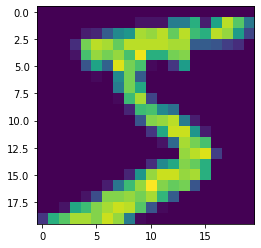

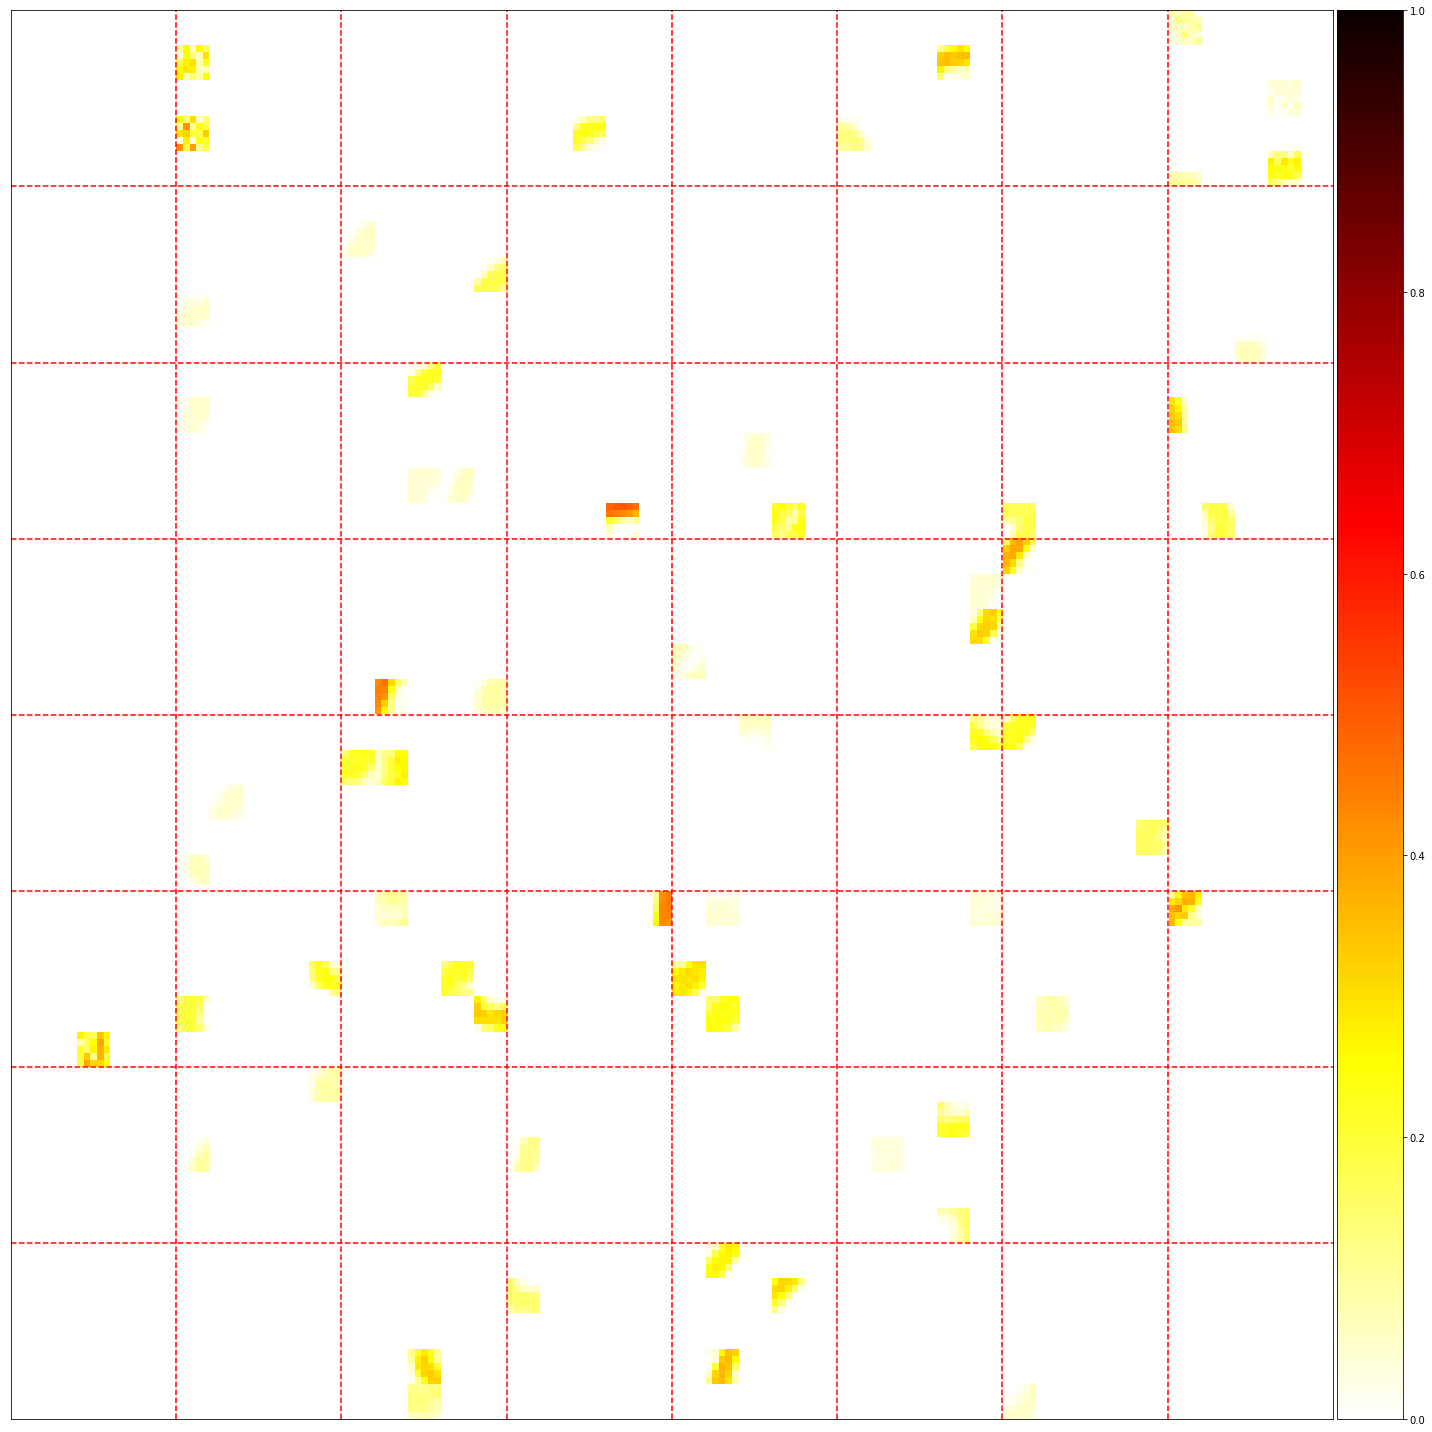

tensor(7)


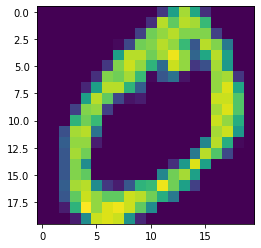

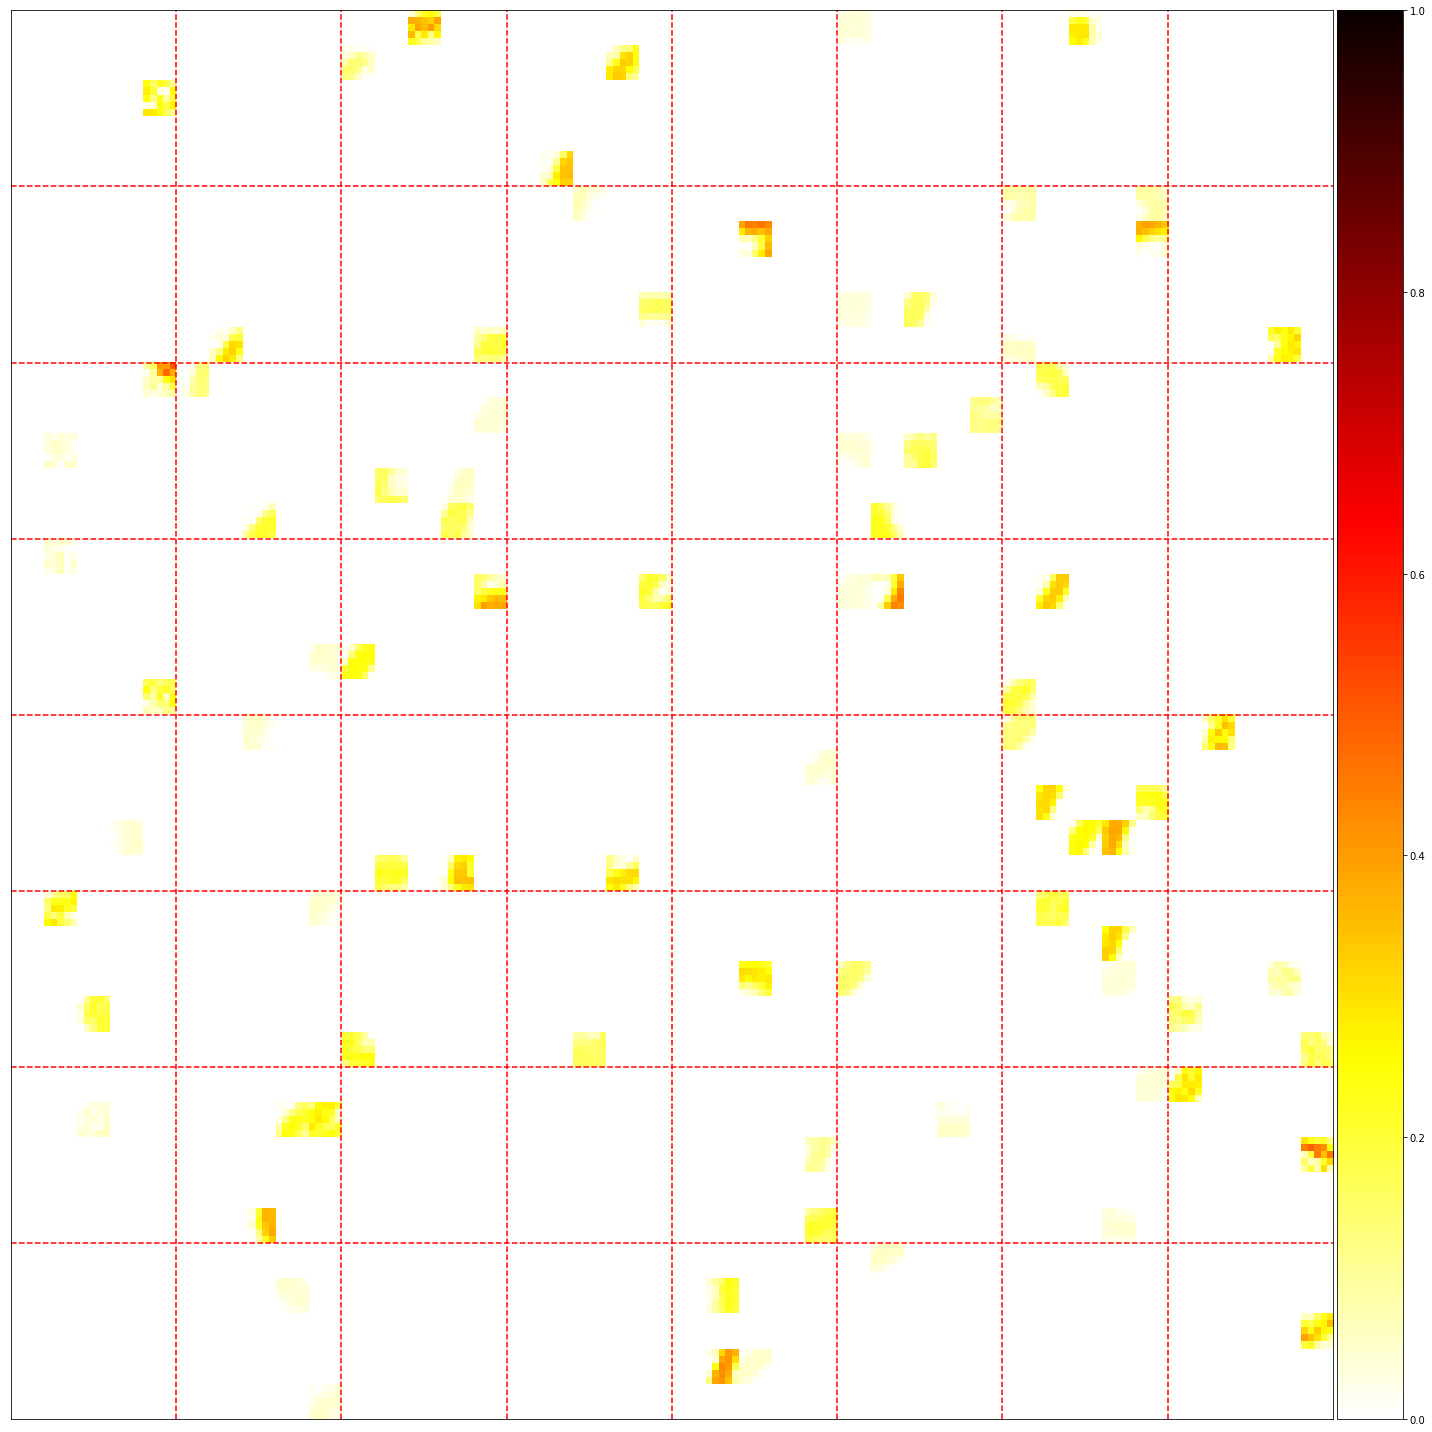

tensor(6)


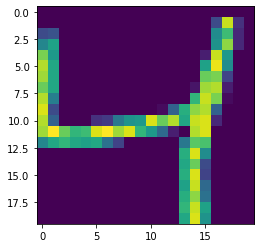

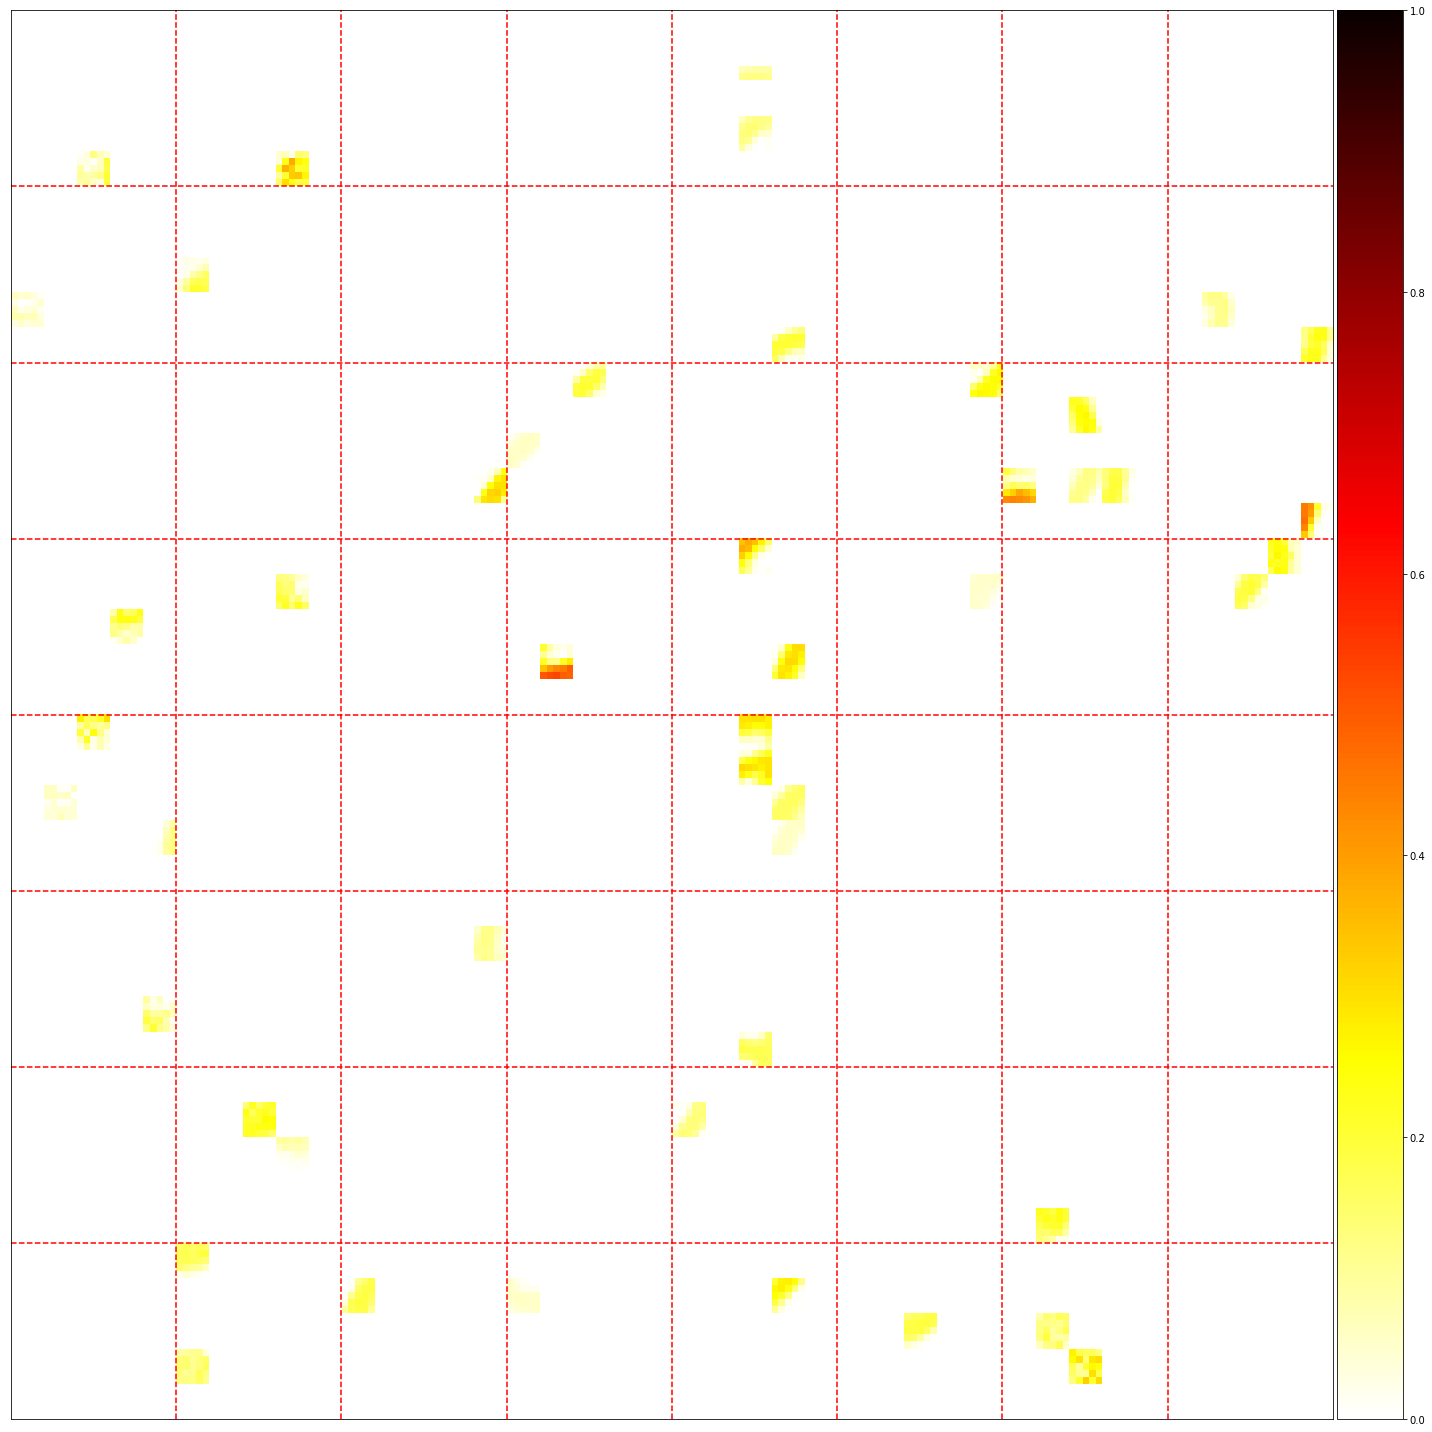

KeyboardInterrupt: ignored

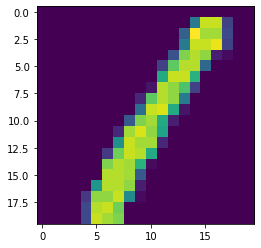

In [ ]:
dataloader_iterator = iter(dataloader)

for i in range(10):
    datum = next(dataloader_iterator)
    plt.imshow(datum['encoded_image'].squeeze().sum(0))
    datum['encoded_image'] = datum['encoded_image'].squeeze(2)
    net.one_step(datum)
    spikes = net.spikes["main1"].get("s").sum(0).squeeze().view(*[int(net.layers["main1"].n**(0.5))]*2)
    print(torch.max(spikes))
    im = plot_locally_connected_activations(
                                    weights= net.connections[("input","main1")].w,
                                    spikes = spikes,
                                    n_filters= hparams["n_channels1"],
                                    in_chans = 0,
                                    locations= net.connections[("input","main1")].locations,
                                    input_size= hparams["crop_size"],
                                    kernel_size= hparams["filter_size1"],
                                    conv_size= compute_size(hparams["crop_size"], hparams["filter_size1"], hparams["stride1"]),
                                    wmin = 0.0,
                                    wmax = 1.0,
                                    figsize=(20, 20),
                                    cmap = "hot_r")
    plt.show()